<a href="https://colab.research.google.com/github/yuqiansi/Carpet-IT-project/blob/main/ML4Health_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas_gbq
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from google.cloud import bigquery
from google.colab import data_table
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.impute import SimpleImputer
from matplotlib.gridspec import GridSpec
data_table.enable_dataframe_formatter()

In [ ]:
from google.colab import auth
auth.authenticate_user()
print('Authenticated')

Authenticated


In [ ]:
#Change you project ID here to run the code
project_id = "my-project-700-401906"
client = bigquery.Client(project=project_id)
dataset = 'mimiciv'

In [ ]:
def fetch_data_from_bigquery(project_id, query):
    query_job = client.query(query)
    df = query_job.to_dataframe()
    return df

In [ ]:
# Define the SQL query to retrieve 'label' and 'itemid' from the dataset
# The query looks for items where the 'label' contains 'creatinine' or 'urine'
itemid_query = """
SELECT label, itemid
FROM `physionet-data.mimiciv_icu.d_items`
WHERE lower(label) LIKE '%creatinine%' OR lower(label) LIKE 'urine%'
"""

itemid_creatin = fetch_data_from_bigquery(project_id, itemid_query)

itemid_creatin


,label,itemid
0,Urine Culture,225454
1,Creatinine (serum),220615
2,Creatinine (whole blood),229761
3,Urine Source,224015
4,Urine Color,224016
5,Urine Appearance,224876
6,Urine and GU Irrigant Out,226566
7,CreatinineApacheIIScore,226751
8,CreatinineApacheIIValue,226752
9,Creatinine_ApacheIV,227005


In [ ]:
creatinine_base_query = """
SELECT
    ce.subject_id,
    patient.gender,
    patient.anchor_age,
    ce.charttime,
    ce.valuenum AS creatinine,
    MIN(ce.charttime) OVER (PARTITION BY ce.subject_id) AS first_time,
    MAX(ce.charttime) OVER (PARTITION BY ce.subject_id) AS last_time
FROM `physionet-data.mimiciv_icu.chartevents` ce
INNER JOIN `physionet-data.mimiciv_hosp.patients` patient
    ON ce.subject_id = patient.subject_id
WHERE ce.itemid IN (220615, 229761)  -- Creatinine
    AND ce.valuenum BETWEEN 0 AND 150
ORDER BY ce.subject_id, ce.charttime
"""

# Get base creatinine data
creatinine_df = fetch_data_from_bigquery(project_id, creatinine_base_query)

In [ ]:
weight_query = """
SELECT
    subject_id,
    charttime,
    ROUND(AVG(CASE
        WHEN itemid = 226512 THEN valuenum
        WHEN itemid = 226531 THEN valuenum * 0.4536
    END), 1) AS weight_kg
FROM `physionet-data.mimiciv_icu.chartevents`
WHERE itemid IN (226512, 226531)  -- Weight measures
    AND valuenum BETWEEN 20 AND 300
GROUP BY subject_id, charttime
ORDER BY subject_id, charttime
"""

weight_df = fetch_data_from_bigquery(project_id, weight_query)

In [ ]:
vitals_query = """
SELECT
    subject_id,
    charttime,
    MAX(CASE WHEN itemid IN (220045, 211) THEN valuenum END) AS heart_rate,
    MAX(CASE WHEN itemid IN (220050, 220179) THEN valuenum END) AS systolic,
    MAX(CASE WHEN itemid IN (220051, 220180) THEN valuenum END) AS diastolic,
    MAX(CASE WHEN itemid = 220277 THEN valuenum END) AS spo2,
    MAX(CASE WHEN itemid IN (220210, 224690) THEN valuenum END) AS resp_rate,
    MAX(CASE
        WHEN itemid = 223761 THEN valuenum
        WHEN itemid = 223762 THEN (valuenum - 32) * 5/9
    END) AS temperature
FROM `physionet-data.mimiciv_icu.chartevents`
WHERE itemid IN (
    220045, 211,    -- HR
    220050, 220179, -- SBP
    220051, 220180, -- DBP
    220277,         -- SpO2
    220210, 224690, -- RR
    223761, 223762  -- Temp
)
AND valuenum IS NOT NULL
GROUP BY subject_id, charttime
ORDER BY subject_id, charttime
"""

vitals_df = fetch_data_from_bigquery(project_id, vitals_query)

In [ ]:
urine_query = """
SELECT
    subject_id,
    charttime,
    value AS urine_output
FROM `physionet-data.mimiciv_icu.outputevents`
WHERE itemid IN (
    226559, 226560, 226561, 226584, 226563,
    226564, 226565, 226567, 226557, 226558
)
AND value > 0
ORDER BY subject_id, charttime
"""

urine_df = fetch_data_from_bigquery(project_id, urine_query)

In [ ]:
def merge_measurements(creatinine_df, weight_df, vitals_df, urine_df,
                      weight_window=24, vitals_window=6, urine_window=6):

    for df in [creatinine_df, weight_df, vitals_df, urine_df]:
        if not pd.api.types.is_datetime64_ns_dtype(df['charttime']):
            df['charttime'] = pd.to_datetime(df['charttime'])

    los = (creatinine_df.groupby('subject_id')['charttime']
           .agg(['min', 'max'])
           .apply(lambda x: (x['max'] - x['min']).days, axis=1)
           .reset_index()
           .rename(columns={0: 'los_days'}))

    weight_window = pd.Timedelta(hours=weight_window)
    vitals_window = pd.Timedelta(hours=vitals_window)
    urine_window = pd.Timedelta(hours=urine_window)

    merged_df = pd.merge_asof(
        creatinine_df.sort_values('charttime'),
        weight_df.sort_values('charttime'),
        by='subject_id',
        on='charttime',
        tolerance=weight_window,
        direction='nearest'
    )

    merged_df = pd.merge_asof(
        merged_df,
        vitals_df.sort_values('charttime'),
        by='subject_id',
        on='charttime',
        tolerance=vitals_window,
        direction='nearest'
    )

    merged_df = pd.merge_asof(
        merged_df,
        urine_df.sort_values('charttime'),
        by='subject_id',
        on='charttime',
        tolerance=urine_window,
        direction='nearest'
    )

    merged_df = pd.merge(merged_df, los, on='subject_id', how='left')

    final_df = merged_df[[
        'subject_id', 'gender', 'anchor_age', 'charttime',
        'creatinine', 'weight_kg', 'los_days',
        'heart_rate', 'temperature', 'systolic', 'diastolic',
        'resp_rate', 'spo2', 'urine_output'
    ]]

    return final_df.sort_values(['subject_id', 'charttime'])

final_df = merge_measurements(creatinine_df, weight_df, vitals_df, urine_df)

def check_data_quality(df):
    """
    Check the quality of merged data
    """
    print("Data shape:", df.shape)
    print("\nMissing values:")
    print(df.isnull().sum())
    print("\nValue ranges:")
    for col in df.select_dtypes(include=['float64', 'int64']).columns:
        print(f"\n{col}:")
        print(f"Min: {df[col].min():.2f}")
        print(f"Max: {df[col].max():.2f}")
        print(f"Mean: {df[col].mean():.2f}")
        print(f"Missing: {df[col].isnull().sum()}")

check_data_quality(final_df)

Data shape: (426002, 14)

Missing values:
subject_id           0
gender               0
anchor_age           0
charttime            0
creatinine           0
weight_kg       202616
los_days             0
heart_rate       86754
temperature     314478
systolic        105476
diastolic       105524
resp_rate        86446
spo2             92889
urine_output     38599
dtype: int64

Value ranges:

subject_id:
Min: 10000032.00
Max: 19999987.00
Mean: 14996601.47
Missing: 0

anchor_age:
Min: 18.00
Max: 91.00
Mean: 62.75
Missing: 0

creatinine:
Min: 0.00
Max: 117.00
Mean: 1.56
Missing: 0

weight_kg:
Min: 10.00
Max: 297.70
Mean: 80.93
Missing: 202616

los_days:
Min: 0.00
Max: 4277.00
Mean: 317.48
Missing: 0

heart_rate:
Min: 0.00
Max: 941.00
Mean: 86.56
Missing: 86754

temperature:
Min: -17.78
Max: 974.00
Mean: 80.79
Missing: 314478

systolic:
Min: -22.00
Max: 344.00
Mean: 118.96
Missing: 105476

diastolic:
Min: -26.00
Max: 50186.00
Mean: 62.70
Missing: 105524

resp_rate:
Min: 0.00
Max: 237890.00
M

In [ ]:
final_df

,subject_id,gender,anchor_age,charttime,creatinine,weight_kg,los_days,heart_rate,temperature,systolic,diastolic,resp_rate,spo2,urine_output
353650,10000032,F,52,2180-07-23 21:45:00,0.50,39.30,0,94.00,NaN,85.00,55.00,20.00,95.00,NaN
234395,10001217,F,55,2157-11-21 03:16:00,0.40,71.00,28,89.00,NaN,141.00,72.00,19.00,98.00,600.00
235042,10001217,F,55,2157-12-20 01:45:00,0.50,74.70,28,79.00,NaN,110.00,66.00,16.00,94.00,225.00
532,10001725,F,46,2110-04-11 18:02:00,0.80,72.00,0,NaN,NaN,107.00,67.00,17.00,NaN,300.00
535,10001725,F,46,2110-04-12 02:59:00,0.80,72.00,0,83.00,NaN,96.00,59.00,16.00,97.00,60.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
271863,19999840,M,58,2164-09-17 02:49:00,0.80,NaN,5,87.00,NaN,82.00,51.00,17.00,94.00,20.00
271867,19999840,M,58,2164-09-17 07:55:00,0.80,NaN,5,85.00,98.20,99.00,63.00,23.00,93.00,30.00
271869,19999840,M,58,2164-09-17 13:13:00,0.70,NaN,5,NaN,NaN,NaN,NaN,NaN,98.00,20.00
169199,19999987,F,57,2145-11-03 01:35:00,1.30,94.00,1,94.00,NaN,113.00,81.00,20.00,100.00,110.00


In [ ]:
# Convert 'charttime' to datetime format
final_df['charttime'] = pd.to_datetime(final_df['charttime'])

# Sort the dataframe by patient ID and measurement time
final_df = final_df.sort_values(['subject_id', 'charttime'])

final_df = final_df.groupby(['subject_id', 'creatinine']).first().reset_index()

final_df.head(100)


,subject_id,creatinine,gender,anchor_age,charttime,weight_kg,los_days,heart_rate,temperature,systolic,diastolic,resp_rate,spo2,urine_output
0,10000032,0.50,F,52,2180-07-23 21:45:00,39.30,0,94.00,NaN,85.00,55.00,20.00,95.00,NaN
1,10001217,0.40,F,55,2157-11-21 03:16:00,71.00,28,89.00,NaN,141.00,72.00,19.00,98.00,600.00
2,10001217,0.50,F,55,2157-12-20 01:45:00,74.70,28,79.00,NaN,110.00,66.00,16.00,94.00,225.00
3,10001725,0.80,F,46,2110-04-11 18:02:00,72.00,0,83.00,NaN,107.00,67.00,17.00,97.00,300.00
4,10001884,0.50,F,68,2131-01-18 02:51:00,NaN,7,67.00,NaN,NaN,NaN,17.00,99.00,180.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,10004401,1.60,M,82,2144-02-04 02:24:00,90.70,142,81.00,100.00,106.00,42.00,16.00,96.00,35.00
96,10004401,1.70,M,82,2144-02-04 17:57:00,NaN,142,70.00,NaN,115.00,45.00,21.00,94.00,180.00
97,10004401,1.80,M,82,2144-06-09 03:51:00,NaN,142,70.00,100.10,105.00,47.00,22.00,93.00,80.00
98,10004401,1.90,M,82,2144-01-29 02:11:00,75.80,142,82.00,NaN,119.00,48.00,20.00,98.00,40.00


In [ ]:
def identify_aki(group):
    # Sort the group by charttime to ensure chronological order
    group = group.sort_values('charttime')

    # Calculate creatinine-based metrics
    group['creatinine_change'] = group['creatinine'].diff()
    baseline_creatinine = group['creatinine'].iloc[0]
    group['creatinine_ratio'] = group['creatinine'] / baseline_creatinine

    # Calculate time difference between measurements in hours
    group['time_diff'] = group['charttime'].diff().dt.total_seconds() / 3600

    # Creatinine conditions for AKI
    condition1 = (group['creatinine_change'] >= 0.3) & (group['time_diff'] <= 48)
    condition2 = (group['creatinine_ratio'] >= 1.5) & (group['time_diff'] <= 168)

    # Calculate urine output per kg per hour
    if 'urine_output' in group.columns and 'weight_kg' in group.columns:
        group['uo_per_kg_hour'] = group['urine_output'] / (group['weight_kg'])

        # Calculate 6-hour rolling average of urine output using 'h' instead of 'H'
        group['uo_6hr_avg'] = group.rolling(
            window='6h',
            on='charttime'
        )['uo_per_kg_hour'].mean()

        # Urine output condition: ≤0.5 mL/kg/hour for 6 hours
        condition3 = (group['uo_6hr_avg'] <= 0.5) & (group['uo_6hr_avg'] > 0)
    else:
        condition3 = pd.Series(False, index=group.index)

    # Define threshold for high baseline creatinine
    high_baseline_threshold = 1.2
    pre_existing_kidney_issue = 1 if baseline_creatinine > high_baseline_threshold else 0

    if condition1.any() or condition2.any() or condition3.any():
        # AKI detected: find earliest detection time from any condition
        aki_times = []

        if condition1.any():
            aki_times.append(group[condition1]['charttime'].min())
        if condition2.any():
            aki_times.append(group[condition2]['charttime'].min())
        if condition3.any():
            aki_times.append(group[condition3]['charttime'].min())

        aki_time = min(aki_times)

        return pd.Series({
            'aki': 1,
            'aki_onset': aki_time,
            'pre_existing_kidney_issue': pre_existing_kidney_issue,
            'aki_by_creatinine': 1 if (condition1.any() or condition2.any()) else 0,
            'aki_by_urine': 1 if condition3.any() else 0
        })
    else:
        # No AKI detected
        return pd.Series({
            'aki': 0,
            'aki_onset': pd.NaT,
            'pre_existing_kidney_issue': pre_existing_kidney_issue,
            'aki_by_creatinine': 0,
            'aki_by_urine': 0
        })

In [ ]:
#Apply AKI identification function
#Note: This step takes around 12-13 minutes to run
aki_results = final_df.groupby('subject_id').apply(identify_aki).reset_index()

#Merge AKI results with original data
final_df = final_df.merge(aki_results, on='subject_id', how='left')

<ipython-input-72-c5a910847c19>:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  aki_results = final_df.groupby('subject_id').apply(identify_aki).reset_index()


In [ ]:
# We only interested in these columns here, so we kept only these columns from the 'final_df'
final_cohort = final_df[['subject_id', 'gender', 'anchor_age', 'weight_kg', 'charttime', 'los_days', 'creatinine', 'urine_output', 'heart_rate', 'temperature', 'systolic', 'diastolic', 'resp_rate', 'spo2', 'aki', 'aki_onset']]
final_cohort = final_cohort.drop_duplicates()
final_cohort.head()

,subject_id,gender,anchor_age,weight_kg,charttime,los_days,creatinine,urine_output,heart_rate,temperature,systolic,diastolic,resp_rate,spo2,aki,aki_onset
0,10000032,F,52,39.30,2180-07-23 21:45:00,0,0.50,NaN,94.00,NaN,85.00,55.00,20.00,95.00,0,NaT
1,10001217,F,55,71.00,2157-11-21 03:16:00,28,0.40,600.00,89.00,NaN,141.00,72.00,19.00,98.00,0,NaT
2,10001217,F,55,74.70,2157-12-20 01:45:00,28,0.50,225.00,79.00,NaN,110.00,66.00,16.00,94.00,0,NaT
3,10001725,F,46,72.00,2110-04-11 18:02:00,0,0.80,300.00,83.00,NaN,107.00,67.00,17.00,97.00,0,NaT
4,10001884,F,68,NaN,2131-01-18 02:51:00,7,0.50,180.00,67.00,NaN,NaN,NaN,17.00,99.00,1,2131-01-13 04:29:00


In [ ]:
def get_patient_summary(group):
    # Basic patient information
    age = group['anchor_age'].iloc[0]
    gender = 1 if group['gender'].iloc[0] == 'M' else 0
    weight = group['weight_kg'].mean()

    # Time-related information
    first_time = pd.to_datetime(group['charttime'].iloc[0])
    last_time = pd.to_datetime(group['charttime'].iloc[-1])
    length_of_stay = group['los_days'].iloc[-1]

    # Creatinine measurements
    baseline_creatinine = group['creatinine'].iloc[0]
    max_creatinine = group['creatinine'].max()
    min_creatinine = group['creatinine'].min()

    # Handle division by zero in percent change calculation
    try:
        percent_change = round((max_creatinine - baseline_creatinine) / baseline_creatinine * 100, 2) if baseline_creatinine != 0 else 0
    except:
        percent_change = 0

    # Urine output statistics
    mean_urine = group['urine_output'].mean()
    min_urine = group['urine_output'].min()
    max_urine = group['urine_output'].max()

    hr_stats = group['heart_rate'].agg(['mean', 'min', 'max']).fillna(0)
    temp_stats = group['temperature'].agg(['mean', 'min', 'max']).fillna(0)
    sbp_stats = group['systolic'].agg(['mean', 'min', 'max']).fillna(0)
    dbp_stats = group['diastolic'].agg(['mean', 'min', 'max']).fillna(0)
    rr_stats = group['resp_rate'].agg(['mean', 'min', 'max']).fillna(0)
    spo2_stats = group['spo2'].agg(['mean', 'min', 'max']).fillna(0)

    # AKI information
    aki_status = group['aki'].max()
    aki_onset = group['aki_onset'].min() if aki_status == 1 else pd.NaT

    return pd.Series({
        'age': age,
        'gender': gender,
        'weight_kg': weight,

        # Time-related metrics
        'first_measurement': first_time,
        'last_measurement': last_time,
        'length_of_stay': length_of_stay,
        'measurement_count': len(group),

        # Creatinine metrics
        'baseline_creatinine': baseline_creatinine,
        'max_creatinine': max_creatinine,
        'min_creatinine': min_creatinine,
        'absolute_creatinine_change': round(max_creatinine - baseline_creatinine, 2),
        'percent_creatinine_change': percent_change,

        # Urine output metrics
        'mean_urine_output': mean_urine,
        'min_urine_output': min_urine,
        'max_urine_output': max_urine,

        # Vital signs metrics
        'heart_rate_mean': hr_stats['mean'],
        'heart_rate_min': hr_stats['min'],
        'heart_rate_max': hr_stats['max'],

        'temperature_mean': temp_stats['mean'],
        'temperature_min': temp_stats['min'],
        'temperature_max': temp_stats['max'],

        'systolic_mean': sbp_stats['mean'],
        'systolic_min': sbp_stats['min'],
        'systolic_max': sbp_stats['max'],

        'diastolic_mean': dbp_stats['mean'],
        'diastolic_min': dbp_stats['min'],
        'diastolic_max': dbp_stats['max'],

        'resp_rate_mean': rr_stats['mean'],
        'resp_rate_min': rr_stats['min'],
        'resp_rate_max': rr_stats['max'],

        'spo2_mean': spo2_stats['mean'],
        'spo2_min': spo2_stats['min'],
        'spo2_max': spo2_stats['max'],

        # AKI information
        'aki': aki_status,
        'aki_onset': aki_onset,
        'time_to_aki': (aki_onset - first_time).total_seconds()/86400 if pd.notna(aki_onset) else None
    })

def analyze_cohort(final_cohort):
    patient_summary = (final_cohort.groupby('subject_id', group_keys=False)
                      .apply(get_patient_summary)
                      .reset_index())

    pd.set_option('display.float_format', '{:.2f}'.format)

    print("Cohort Summary:")
    print("--------------")
    print(f"Total patients: {len(patient_summary)}")
    print(f"AKI patients: {patient_summary['aki'].sum():.0f}")
    print(f"AKI incidence rate: {patient_summary['aki'].mean():.2%}")

    print("\nDemographics:")
    print("------------")
    print(f"Average age: {patient_summary['age'].mean():.2f} years")
    print(f"Male patients: {(patient_summary['gender'] == 1).mean():.2%}")
    print(f"Average weight: {patient_summary['weight_kg'].mean():.2f} kg")

    print("\nLength of Stay:")
    print("-------------")
    los_stats = patient_summary['length_of_stay'].describe()
    print(f"Mean: {los_stats['mean']:.2f} days")
    print(f"Median: {los_stats['50%']:.2f} days")
    print(f"Range: {los_stats['min']:.2f} - {los_stats['max']:.2f} days")

    print("\nVital Signs (Mean ± SD):")
    print("----------------------")
    vital_signs = ['heart_rate_mean', 'temperature_mean', 'systolic_mean', 'spo2_mean']
    for vital in vital_signs:
        stats = patient_summary[vital].describe()
        print(f"{vital}: {stats['mean']:.1f} ± {stats['std']:.1f}")

    return patient_summary

patient_summary = analyze_cohort(final_cohort)

Cohort Summary:
--------------
Total patients: 49640
AKI patients: 18847
AKI incidence rate: 37.97%

Demographics:
------------
Average age: 63.55 years
Male patients: 56.01%
Average weight: 81.08 kg

Length of Stay:
-------------
Mean: 124.39 days
Median: 1.00 days
Range: 0.00 - 4277.00 days

Vital Signs (Mean ± SD):
----------------------
heart_rate_mean: 79.9 ± 23.7
temperature_mean: 55.1 ± 47.6
systolic_mean: 111.8 ± 33.8
spo2_mean: 91.7 ± 26.7


<ipython-input-74-0b73bced2cb1>:95: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(get_patient_summary)


In [ ]:
patient_summary.head()

,subject_id,age,gender,weight_kg,first_measurement,last_measurement,length_of_stay,measurement_count,baseline_creatinine,max_creatinine,...,diastolic_max,resp_rate_mean,resp_rate_min,resp_rate_max,spo2_mean,spo2_min,spo2_max,aki,aki_onset,time_to_aki
0,10000032,52,0,39.30,2180-07-23 21:45:00,2180-07-23 21:45:00,0,1,0.50,0.50,...,55.00,20.00,20.00,20.00,95.00,95.00,95.00,0,NaT,NaN
1,10001217,55,0,72.85,2157-11-21 03:16:00,2157-12-20 01:45:00,28,2,0.40,0.50,...,72.00,17.50,16.00,19.00,96.00,94.00,98.00,0,NaT,NaN
2,10001725,46,0,72.00,2110-04-11 18:02:00,2110-04-11 18:02:00,0,1,0.80,0.80,...,67.00,17.00,17.00,17.00,97.00,97.00,97.00,0,NaT,NaN
3,10001884,68,0,64.95,2131-01-18 02:51:00,2131-01-13 08:23:00,7,9,0.50,1.30,...,93.00,17.00,13.00,20.00,97.50,90.00,100.00,1,2131-01-13 04:29:00,-4.93
4,10002013,53,0,95.80,2160-05-19 04:00:00,2160-05-18 14:38:00,0,2,0.90,1.10,...,0.00,12.00,12.00,12.00,98.00,98.00,98.00,1,2160-05-19 04:00:00,0.00


In [ ]:
# Remove outliers, assume creatinine values above 20 are abnormal
def filter_and_clean_data(patient_summary):

    patient_summary = patient_summary[patient_summary['max_creatinine'] < 20]

    # Remove patients with insufficient measurements, I kept only patients with 2 or more measurements
    patient_summary = patient_summary[patient_summary['measurement_count'] >= 2]

    return patient_summary

In [ ]:
cleaned_data = filter_and_clean_data(patient_summary)
cleaned_data

,subject_id,age,gender,weight_kg,first_measurement,last_measurement,length_of_stay,measurement_count,baseline_creatinine,max_creatinine,...,diastolic_max,resp_rate_mean,resp_rate_min,resp_rate_max,spo2_mean,spo2_min,spo2_max,aki,aki_onset,time_to_aki
1,10001217,55,0,72.85,2157-11-21 03:16:00,2157-12-20 01:45:00,28,2,0.40,0.50,...,72.00,17.50,16.00,19.00,96.00,94.00,98.00,0,NaT,NaN
3,10001884,68,0,64.95,2131-01-18 02:51:00,2131-01-13 08:23:00,7,9,0.50,1.30,...,93.00,17.00,13.00,20.00,97.50,90.00,100.00,1,2131-01-13 04:29:00,-4.93
4,10002013,53,0,95.80,2160-05-19 04:00:00,2160-05-18 14:38:00,0,2,0.90,1.10,...,0.00,12.00,12.00,12.00,98.00,98.00,98.00,1,2160-05-19 04:00:00,0.00
5,10002155,80,0,43.07,2129-08-04 17:56:00,2130-09-24 03:55:00,582,10,0.90,2.50,...,66.00,15.89,13.00,19.00,93.78,90.00,100.00,1,2130-09-25 01:49:00,416.33
6,10002348,77,0,41.60,2112-12-07 06:10:00,2112-12-05 02:53:00,9,4,0.60,0.90,...,74.00,18.50,18.00,19.00,93.00,92.00,94.00,0,NaT,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49635,19999442,41,1,107.40,2148-11-21 03:03:00,2148-11-19 16:55:00,6,4,0.60,0.90,...,86.00,18.25,16.00,20.00,97.00,95.00,98.00,0,NaT,NaN
49636,19999625,81,1,50.45,2139-10-11 04:21:00,2139-10-10 23:25:00,0,2,2.30,2.50,...,59.00,19.50,19.00,20.00,99.50,99.00,100.00,0,NaT,NaN
49637,19999828,46,0,67.90,2149-01-09 07:58:00,2149-01-09 19:39:00,1,3,0.60,0.80,...,76.00,14.33,13.00,17.00,99.67,99.00,100.00,0,NaT,NaN
49638,19999840,58,1,77.50,2164-09-15 02:32:00,2164-09-12 09:31:00,5,4,0.50,0.80,...,64.00,16.00,14.00,20.00,97.50,95.00,99.00,0,NaT,NaN


In [ ]:
def handle_missing_and_infinite_values(df):
    """
    This function handles missing and infinite values in a dataframe by:
    1. Replacing infinite values with NaN.
    2. Imputing missing (and now infinite) values using the median.

    Median is chosen because:
    - It is robust to outliers and extreme values, preventing skewed data from affecting imputation.
    - It provides a more accurate central tendency measure for skewed data distributions.
    - It helps preserve the original data distribution better in cases where the data is non-normally distributed.
    """

    print("Missing values per column:\n", df.isnull().sum())
    print("\nInfinite values per column:\n", df.isin([np.inf, -np.inf]).sum())

    # Replace infinite values with NaN
    df = df.replace([np.inf, -np.inf], np.nan)

    # Impute missing values using the median
    # Median is chosen as it is more robust to outliers and ensures better handling of skewed data distributions.
    imputer = SimpleImputer(strategy='median')
    df_imputed = pd.DataFrame(imputer.fit_transform(df), columns=df.columns, index=df.index)

    return df_imputed


In [ ]:
cleaned_data = filter_and_clean_data(patient_summary)
cleaned_data.head(10)

,subject_id,age,gender,weight_kg,first_measurement,last_measurement,length_of_stay,measurement_count,baseline_creatinine,max_creatinine,...,diastolic_max,resp_rate_mean,resp_rate_min,resp_rate_max,spo2_mean,spo2_min,spo2_max,aki,aki_onset,time_to_aki
1,10001217,55,0,72.85,2157-11-21 03:16:00,2157-12-20 01:45:00,28,2,0.40,0.50,...,72.00,17.50,16.00,19.00,96.00,94.00,98.00,0,NaT,NaN
3,10001884,68,0,64.95,2131-01-18 02:51:00,2131-01-13 08:23:00,7,9,0.50,1.30,...,93.00,17.00,13.00,20.00,97.50,90.00,100.00,1,2131-01-13 04:29:00,-4.93
4,10002013,53,0,95.80,2160-05-19 04:00:00,2160-05-18 14:38:00,0,2,0.90,1.10,...,0.00,12.00,12.00,12.00,98.00,98.00,98.00,1,2160-05-19 04:00:00,0.00
5,10002155,80,0,43.07,2129-08-04 17:56:00,2130-09-24 03:55:00,582,10,0.90,2.50,...,66.00,15.89,13.00,19.00,93.78,90.00,100.00,1,2130-09-25 01:49:00,416.33
6,10002348,77,0,41.60,2112-12-07 06:10:00,2112-12-05 02:53:00,9,4,0.60,0.90,...,74.00,18.50,18.00,19.00,93.00,92.00,94.00,0,NaT,NaN
7,10002428,80,0,47.47,2156-05-01 01:53:00,2156-04-16 02:48:00,39,7,0.30,1.30,...,67.00,22.14,14.00,28.00,96.86,94.00,99.00,1,2156-04-16 02:48:00,-14.96
8,10002430,86,1,57.93,2129-06-13 00:48:00,2129-06-15 04:49:00,2,3,2.20,2.40,...,65.00,25.67,22.00,30.00,94.00,91.00,99.00,0,NaT,NaN
9,10002443,53,1,156.10,2183-10-20 15:30:00,2183-10-18 21:40:00,2,4,0.60,0.90,...,81.00,23.00,13.00,30.00,95.67,95.00,96.00,0,NaT,NaN
10,10002495,81,1,64.00,2141-05-26 09:21:00,2141-05-23 05:48:00,4,4,1.30,1.60,...,68.00,22.00,18.00,26.00,97.67,95.00,100.00,0,NaT,NaN
12,10002930,48,0,66.95,2198-04-18 03:06:00,2196-04-15 03:36:00,732,2,0.50,0.60,...,79.00,13.00,13.00,13.00,96.50,96.00,97.00,1,2196-04-15 03:36:00,-732.98


In [ ]:
# Filter out rows where 'length_of_stay' is 0, then select rows with 'aki' == 1
aki_diag_data = cleaned_data[(cleaned_data['aki'] == 1) & (cleaned_data['length_of_stay'] != 0)]

aki_diag_data.head()


,subject_id,age,gender,weight_kg,first_measurement,last_measurement,length_of_stay,measurement_count,baseline_creatinine,max_creatinine,...,diastolic_max,resp_rate_mean,resp_rate_min,resp_rate_max,spo2_mean,spo2_min,spo2_max,aki,aki_onset,time_to_aki
3,10001884,68,0,64.95,2131-01-18 02:51:00,2131-01-13 08:23:00,7,9,0.50,1.30,...,93.00,17.00,13.00,20.00,97.50,90.00,100.00,1,2131-01-13 04:29:00,-4.93
5,10002155,80,0,43.07,2129-08-04 17:56:00,2130-09-24 03:55:00,582,10,0.90,2.50,...,66.00,15.89,13.00,19.00,93.78,90.00,100.00,1,2130-09-25 01:49:00,416.33
7,10002428,80,0,47.47,2156-05-01 01:53:00,2156-04-16 02:48:00,39,7,0.30,1.30,...,67.00,22.14,14.00,28.00,96.86,94.00,99.00,1,2156-04-16 02:48:00,-14.96
12,10002930,48,0,66.95,2198-04-18 03:06:00,2196-04-15 03:36:00,732,2,0.50,0.60,...,79.00,13.00,13.00,13.00,96.50,96.00,97.00,1,2196-04-15 03:36:00,-732.98
15,10003400,72,0,97.73,2137-03-06 03:30:00,2137-08-10 21:55:00,187,15,0.50,2.00,...,89.00,20.20,11.00,27.00,98.40,94.00,100.00,1,2137-02-26 00:15:00,-8.14


In [ ]:
# Print the original shape of the cleaned dataset before filtering
print(f"Original data shape: {cleaned_data.shape}")

# Print the shape of the dataset after filtering for AKI patients and removing rows with 'length_of_stay' = 0
print(f"Filtered data shape: {aki_diag_data.shape}")


Original data shape: (38611, 37)
Filtered data shape: (15700, 37)


In [ ]:
# Extract mortality information from database
mortality_query = """
SELECT subject_id, hadm_id, hospital_expire_flag
FROM `physionet-data.mimiciv_hosp.admissions`
"""
mortality_df = fetch_data_from_bigquery(project_id, mortality_query)


In [ ]:
# Merge mortality data
cleaned_data = aki_diag_data.merge(mortality_df, on='subject_id', how='inner')
cleaned_data.head()

,subject_id,age,gender,weight_kg,first_measurement,last_measurement,length_of_stay,measurement_count,baseline_creatinine,max_creatinine,...,resp_rate_min,resp_rate_max,spo2_mean,spo2_min,spo2_max,aki,aki_onset,time_to_aki,hadm_id,hospital_expire_flag
0,10001884,68,0,64.95,2131-01-18 02:51:00,2131-01-13 08:23:00,7,9,0.50,1.30,...,13.00,20.00,97.50,90.00,100.00,1,2131-01-13 04:29:00,-4.93,21268656,0
1,10001884,68,0,64.95,2131-01-18 02:51:00,2131-01-13 08:23:00,7,9,0.50,1.30,...,13.00,20.00,97.50,90.00,100.00,1,2131-01-13 04:29:00,-4.93,23594368,0
2,10001884,68,0,64.95,2131-01-18 02:51:00,2131-01-13 08:23:00,7,9,0.50,1.30,...,13.00,20.00,97.50,90.00,100.00,1,2131-01-13 04:29:00,-4.93,24746267,0
3,10001884,68,0,64.95,2131-01-18 02:51:00,2131-01-13 08:23:00,7,9,0.50,1.30,...,13.00,20.00,97.50,90.00,100.00,1,2131-01-13 04:29:00,-4.93,24962904,0
4,10001884,68,0,64.95,2131-01-18 02:51:00,2131-01-13 08:23:00,7,9,0.50,1.30,...,13.00,20.00,97.50,90.00,100.00,1,2131-01-13 04:29:00,-4.93,26202981,0


In [ ]:
# Remove all duplicates
cleaned_data = cleaned_data.drop_duplicates()

# Remove duplicates for same patient admission
cleaned_data = cleaned_data.drop_duplicates(subset=['subject_id', 'hadm_id'])

# Aggregate data by patient
aggregated_data = cleaned_data.groupby('subject_id').agg({
    # Creatinine measurements
    'baseline_creatinine': 'mean',
    'max_creatinine': 'max',
    'absolute_creatinine_change': 'mean',
    'percent_creatinine_change': 'mean',
    'min_creatinine': 'min',

    # Vital signs
    'heart_rate_mean': 'mean',
    'systolic_mean': 'mean',
    'diastolic_mean': 'mean',
    'resp_rate_mean': 'mean',
    'spo2_mean': 'mean',
    'temperature_mean': 'mean',

    # Urine output
    'mean_urine_output': 'mean',
    'min_urine_output': 'min',
    'max_urine_output': 'max',

    'measurement_count': 'sum',
    'length_of_stay': 'max',
    'weight_kg': 'mean',
    'age': 'first',
    'gender': 'first',
    'aki': 'max'
}).reset_index()

cleaned_data = cleaned_data.sort_values(by=['subject_id']).drop_duplicates(subset=['subject_id'], keep='last')


In [ ]:
cleaned_data = cleaned_data.drop(['aki_onset', 'time_to_aki'], axis=1)

In [ ]:
cleaned_data.head()

,subject_id,age,gender,weight_kg,first_measurement,last_measurement,length_of_stay,measurement_count,baseline_creatinine,max_creatinine,...,diastolic_max,resp_rate_mean,resp_rate_min,resp_rate_max,spo2_mean,spo2_min,spo2_max,aki,hadm_id,hospital_expire_flag
5,10001884,68,0,64.95,2131-01-18 02:51:00,2131-01-13 08:23:00,7,9,0.50,1.30,...,93.00,17.00,13.00,20.00,97.50,90.00,100.00,1,28475784,0
26,10002155,80,0,43.07,2129-08-04 17:56:00,2130-09-24 03:55:00,582,10,0.90,2.50,...,66.00,15.89,13.00,19.00,93.78,90.00,100.00,1,20345487,1
27,10002428,80,0,47.47,2156-05-01 01:53:00,2156-04-16 02:48:00,39,7,0.30,1.30,...,67.00,22.14,14.00,28.00,96.86,94.00,99.00,1,28676446,0
39,10002930,48,0,66.95,2198-04-18 03:06:00,2196-04-15 03:36:00,732,2,0.50,0.60,...,79.00,13.00,13.00,13.00,96.50,96.00,97.00,1,22733922,0
48,10003400,72,0,97.73,2137-03-06 03:30:00,2137-08-10 21:55:00,187,15,0.50,2.00,...,89.00,20.20,11.00,27.00,98.40,94.00,100.00,1,29483621,0


In [ ]:
print(cleaned_data.columns)

Index(['subject_id', 'age', 'gender', 'weight_kg', 'first_measurement',
       'last_measurement', 'length_of_stay', 'measurement_count',
       'baseline_creatinine', 'max_creatinine', 'min_creatinine',
       'absolute_creatinine_change', 'percent_creatinine_change',
       'mean_urine_output', 'min_urine_output', 'max_urine_output',
       'heart_rate_mean', 'heart_rate_min', 'heart_rate_max',
       'temperature_mean', 'temperature_min', 'temperature_max',
       'systolic_mean', 'systolic_min', 'systolic_max', 'diastolic_mean',
       'diastolic_min', 'diastolic_max', 'resp_rate_mean', 'resp_rate_min',
       'resp_rate_max', 'spo2_mean', 'spo2_min', 'spo2_max', 'aki', 'hadm_id',
       'hospital_expire_flag'],
      dtype='object')


In [ ]:
def demographics_by_outcome(df):
    demographics = df.groupby('hospital_expire_flag').agg(
        age_mean=('age', 'mean'),
        weight_mean=('weight_kg', 'mean'),
        creatinine_mean=('baseline_creatinine', 'mean'),
        absolute_creatinine_change_mean=('absolute_creatinine_change', 'mean'),
        percent_creatinine_change_mean=('percent_creatinine_change', 'mean'),
        urine_output_mean=('mean_urine_output', 'mean'),
        heart_rate_mean=('heart_rate_mean', 'mean'),
        systolic_mean=('systolic_mean', 'mean'),
        diastolic_mean=('diastolic_mean', 'mean'),
        resp_rate_mean=('resp_rate_mean', 'mean'),
        spo2_mean=('spo2_mean', 'mean')
    ).reset_index()
    demographics['Outcome'] = demographics['hospital_expire_flag'].map({0: 'Survived', 1: 'Died'})
    demographics = demographics.drop(columns=['hospital_expire_flag'])
    demographics = demographics.set_index('Outcome').transpose()
    demographics.loc['age_mean'] = demographics.loc['age_mean'].astype(int)
    demographics.loc[demographics.index != 'age_mean'] = demographics.loc[demographics.index != 'age_mean'].round(2)

    return demographics

demographic_data = demographics_by_outcome(cleaned_data)
demographic_data

Outcome,Survived,Died
age_mean,65.00,68.00
weight_mean,85.15,82.64
creatinine_mean,1.17,1.27
absolute_creatinine_change_mean,1.45,1.83
percent_creatinine_change_mean,154.14,204.44
urine_output_mean,128.56,91.64
heart_rate_mean,84.85,89.71
systolic_mean,117.49,112.21
diastolic_mean,62.00,58.53
resp_rate_mean,19.36,21.57


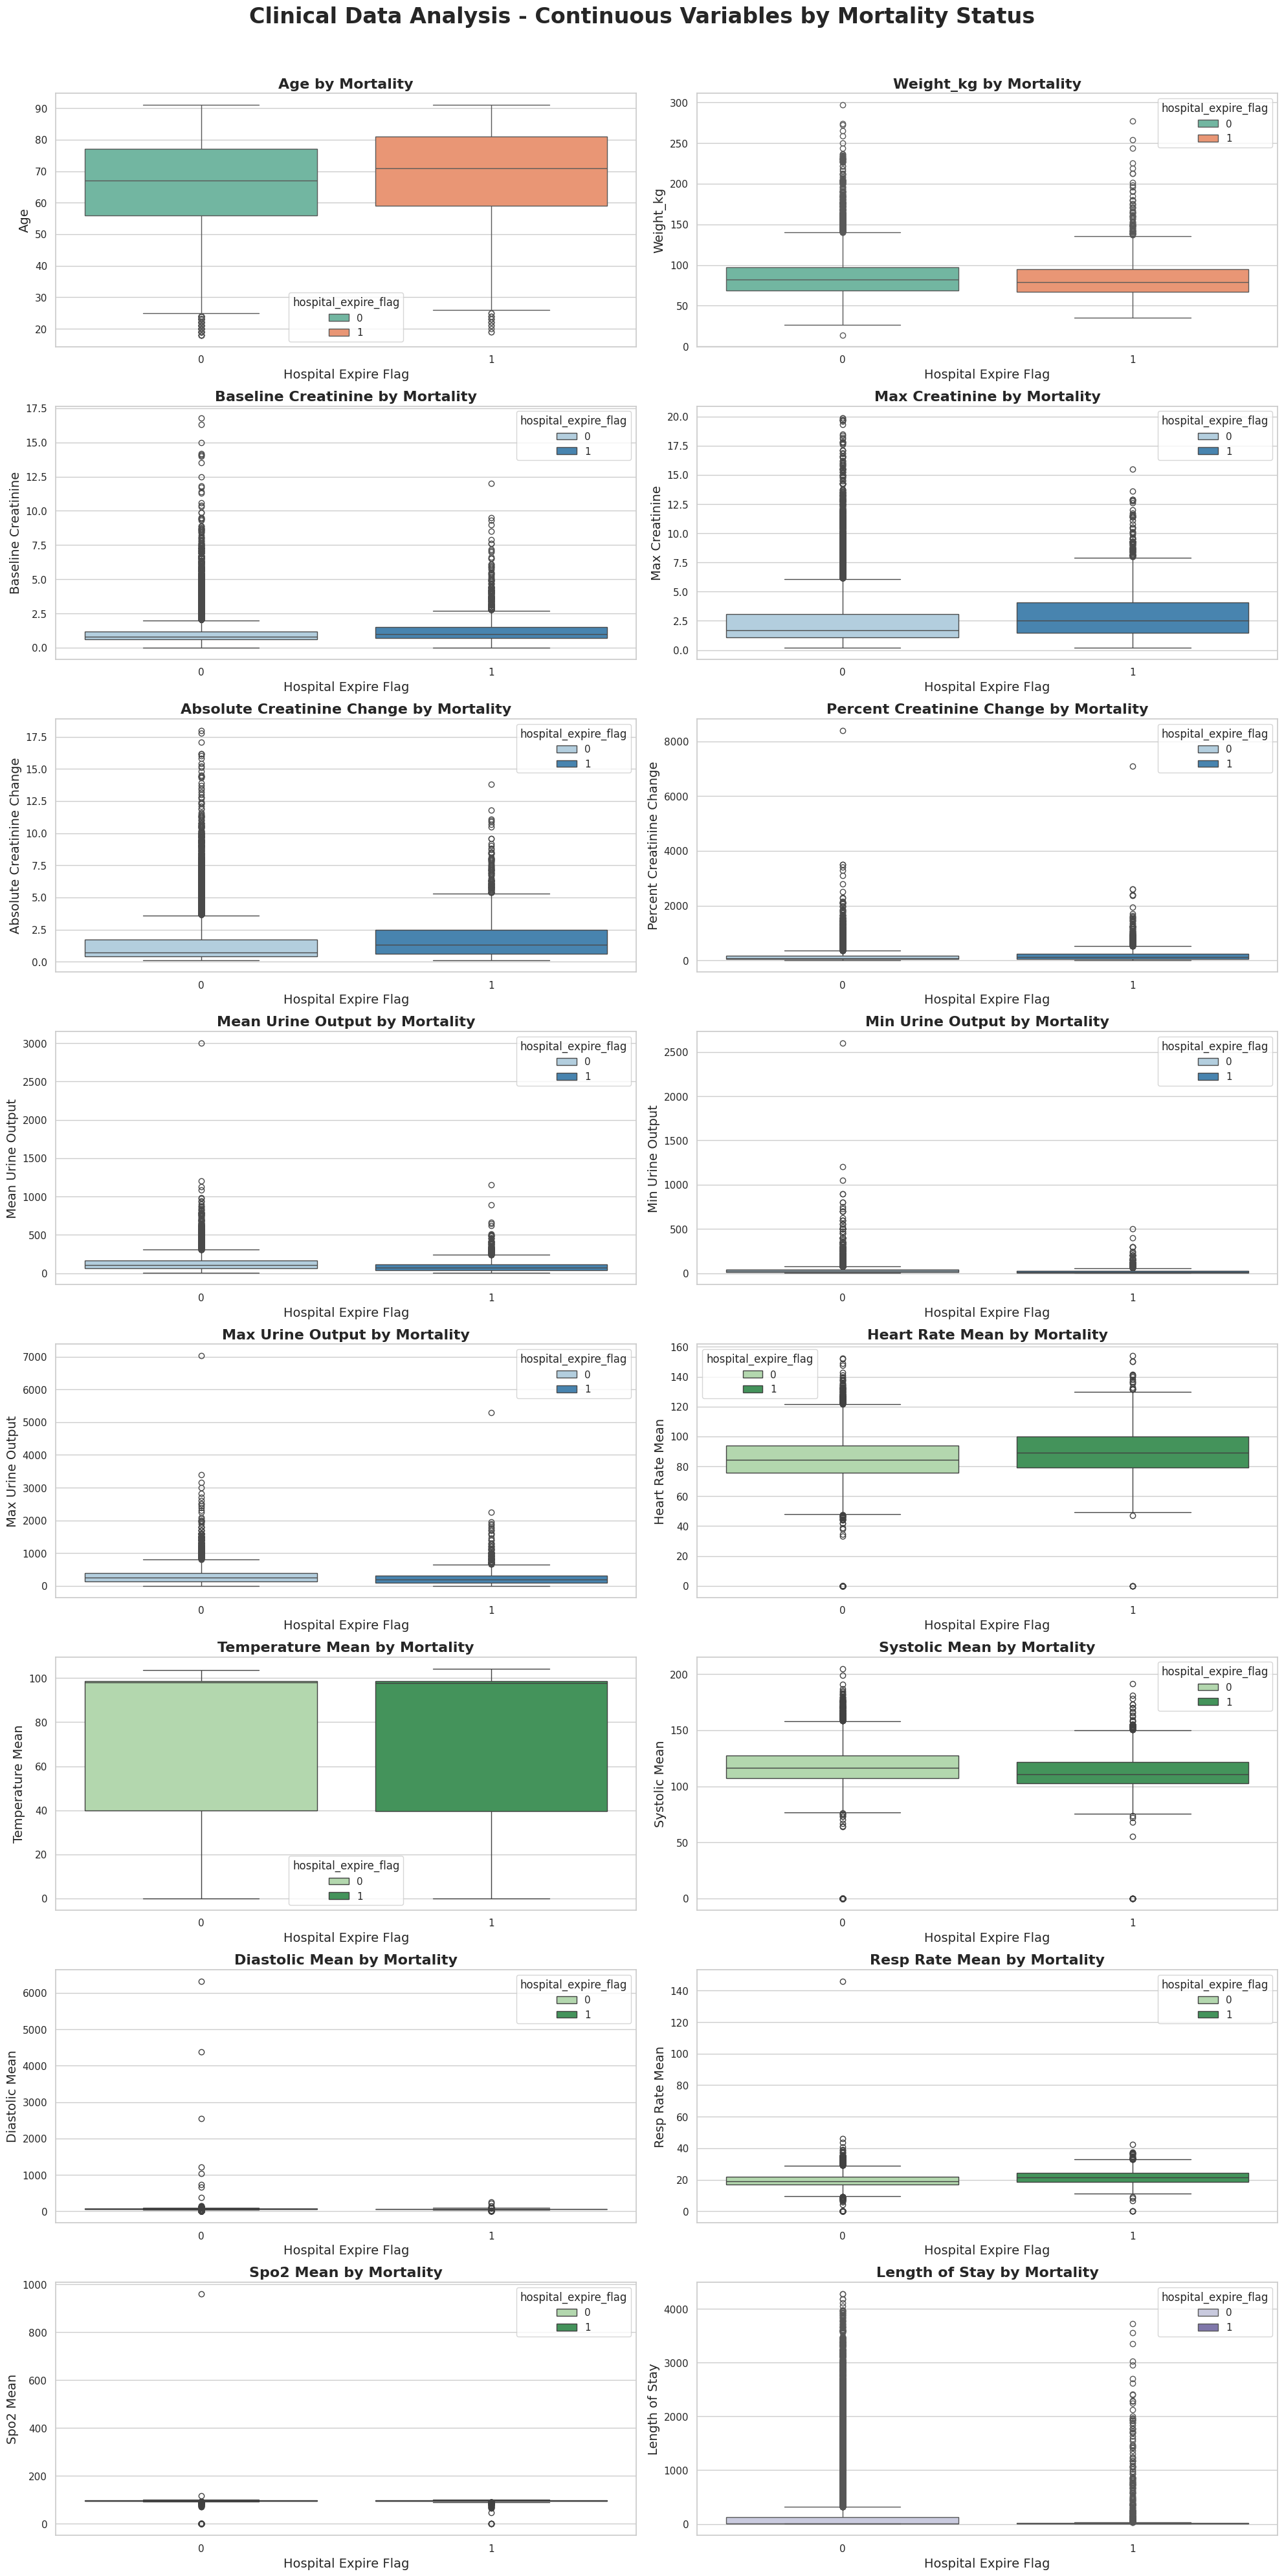

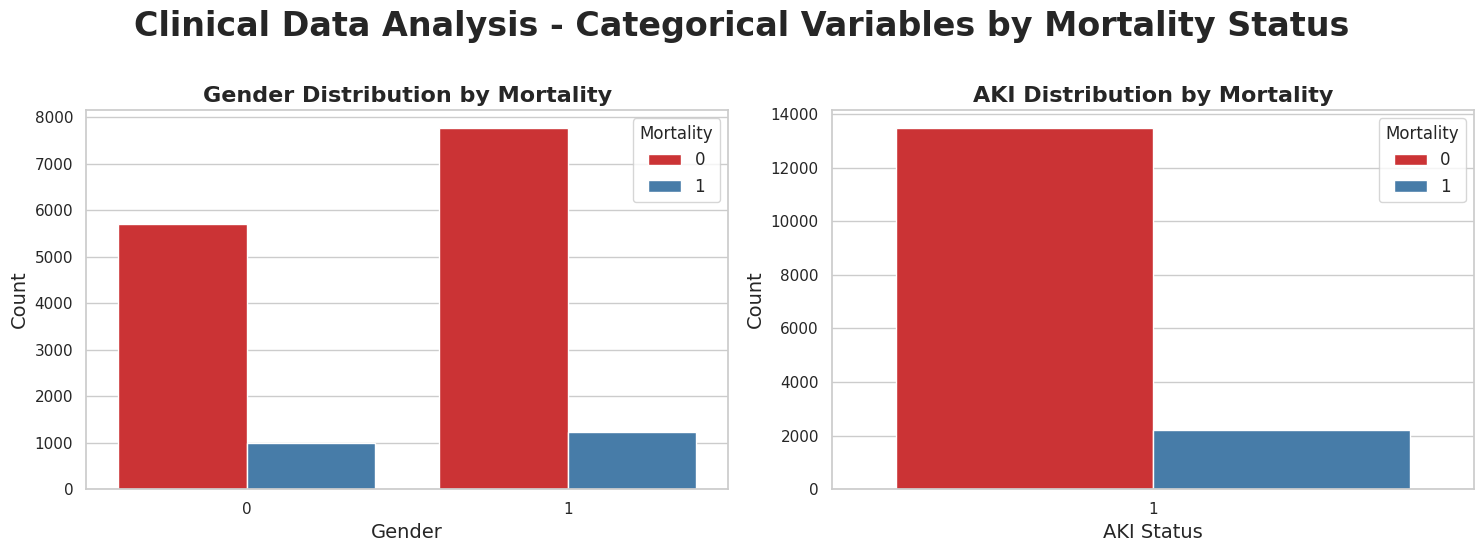

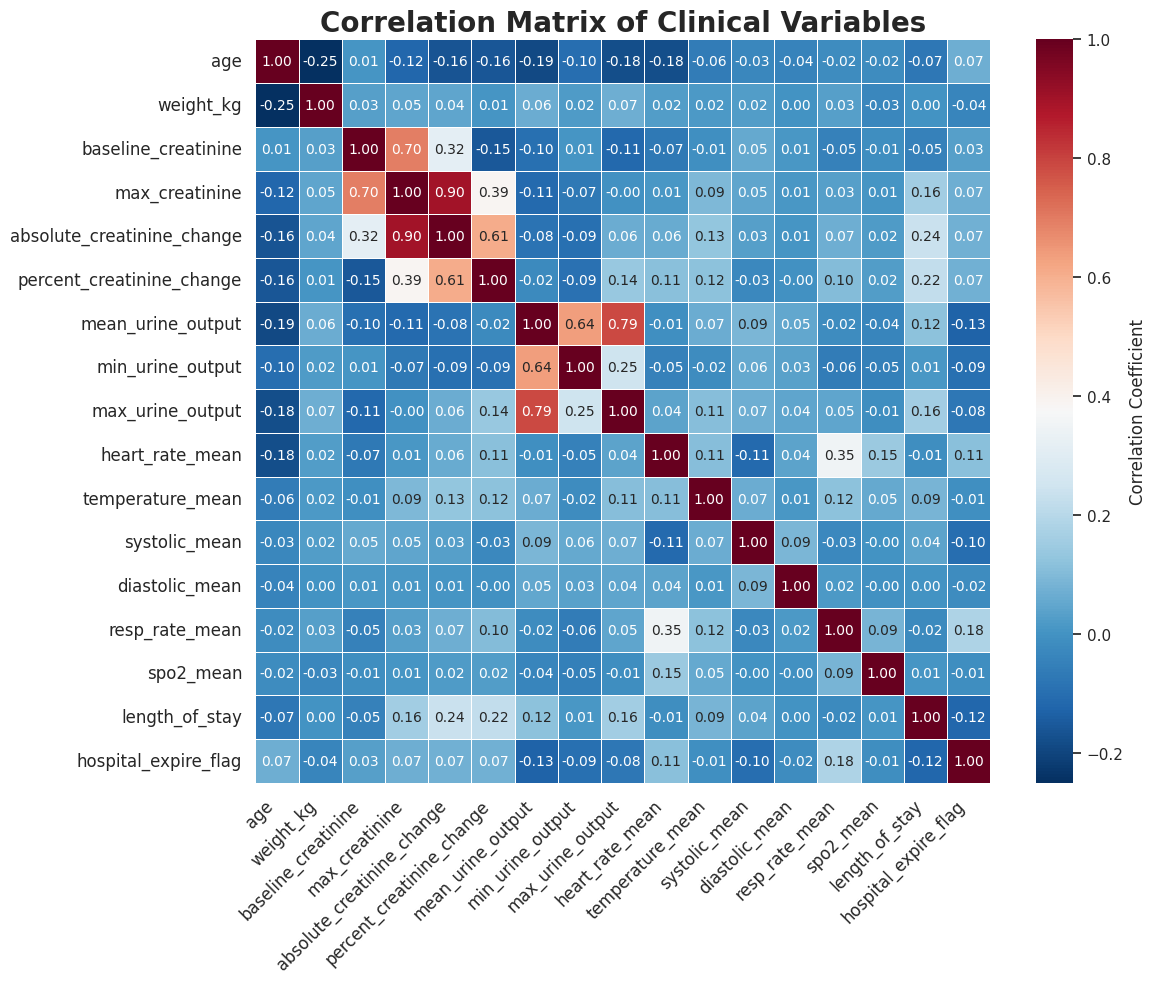


Basic Statistics:
-----------------
Total patients: 15700
Mortality rate: 14.18%
AKI rate: 100.00%

Numerical Variables Summary:
-----------------
           age  weight_kg  baseline_creatinine  max_creatinine  \
count 15700.00   15688.00             15700.00        15700.00   
mean     66.07      84.79                 1.18            2.68   
std      15.37      24.37                 1.11            2.42   
min      18.00      13.90                 0.00            0.20   
25%      57.00      68.41                 0.60            1.10   
50%      68.00      81.39                 0.90            1.80   
75%      78.00      97.10                 1.30            3.30   
max      91.00     296.80                16.80           19.90   

       absolute_creatinine_change  percent_creatinine_change  \
count                    15700.00                   15700.00   
mean                         1.50                     161.27   
std                          1.83                     235.19   
m

In [ ]:
def perform_EDA(cleaned_data):
    sns.set_theme(style="whitegrid")
    demographic_vars = ['age', 'gender', 'weight_kg']
    kidney_vars = [
        'baseline_creatinine', 'max_creatinine', 'absolute_creatinine_change',
        'percent_creatinine_change', 'mean_urine_output', 'min_urine_output',
        'max_urine_output', 'aki'
    ]
    vital_vars = [
        'heart_rate_mean', 'temperature_mean', 'systolic_mean', 'diastolic_mean',
        'resp_rate_mean', 'spo2_mean'
    ]

    total_plots = len(demographic_vars) + len(kidney_vars) + len(vital_vars) + 1
    n_rows = (total_plots + 1) // 2

    fig_box, axes_box = plt.subplots(n_rows, 2, figsize=(20, 5 * n_rows))
    fig_box.suptitle('Clinical Data Analysis - Continuous Variables by Mortality Status', fontsize=24, y=0.98, weight='bold')
    axes_box = axes_box.flatten()
    current_ax = 0

    # Plot continuous demographic variables
    for var in ['age', 'weight_kg']:
        sns.boxplot(data=cleaned_data, x='hospital_expire_flag', y=var, ax=axes_box[current_ax], palette="Set2", hue='hospital_expire_flag', dodge=False)
        axes_box[current_ax].set_title(f'{var.capitalize()} by Mortality', fontsize=16, weight='bold')
        axes_box[current_ax].set_xlabel('Hospital Expire Flag', fontsize=14)
        axes_box[current_ax].set_ylabel(var.capitalize(), fontsize=14)
        current_ax += 1

    # Plot continuous kidney variables
    for var in kidney_vars:
        if var != 'aki':
            sns.boxplot(data=cleaned_data, x='hospital_expire_flag', y=var, ax=axes_box[current_ax], palette="Blues", hue='hospital_expire_flag', dodge=False)
            axes_box[current_ax].set_title(f'{var.replace("_", " ").title()} by Mortality', fontsize=16, weight='bold')
            axes_box[current_ax].set_xlabel('Hospital Expire Flag', fontsize=14)
            axes_box[current_ax].set_ylabel(var.replace('_', ' ').title(), fontsize=14)
            current_ax += 1

    for var in vital_vars:
        sns.boxplot(data=cleaned_data, x='hospital_expire_flag', y=var, ax=axes_box[current_ax], palette="Greens", hue='hospital_expire_flag', dodge=False)
        axes_box[current_ax].set_title(f'{var.replace("_", " ").title()} by Mortality', fontsize=16, weight='bold')
        axes_box[current_ax].set_xlabel('Hospital Expire Flag', fontsize=14)
        axes_box[current_ax].set_ylabel(var.replace('_', ' ').title(), fontsize=14)
        current_ax += 1

    sns.boxplot(data=cleaned_data, x='hospital_expire_flag', y='length_of_stay', ax=axes_box[current_ax], palette="Purples", hue='hospital_expire_flag', dodge=False)
    axes_box[current_ax].set_title('Length of Stay by Mortality', fontsize=16, weight='bold')
    axes_box[current_ax].set_xlabel('Hospital Expire Flag', fontsize=14)
    axes_box[current_ax].set_ylabel('Length of Stay', fontsize=14)

    for i in range(current_ax + 1, len(axes_box)):
        fig_box.delaxes(axes_box[i])

    plt.tight_layout()
    plt.subplots_adjust(top=0.95)
    plt.show()

    # Categorical variable analysis
    fig_cat, axes_cat = plt.subplots(1, 2, figsize=(15, 5))
    fig_cat.suptitle('Clinical Data Analysis - Categorical Variables by Mortality Status', fontsize=24, y=1.1, weight='bold')

    # Gender distribution by mortality
    sns.countplot(data=cleaned_data, x='gender', hue='hospital_expire_flag', ax=axes_cat[0], palette="Set1")
    axes_cat[0].set_title('Gender Distribution by Mortality', fontsize=16, weight='bold')
    axes_cat[0].set_xlabel('Gender', fontsize=14)
    axes_cat[0].set_ylabel('Count', fontsize=14)
    axes_cat[0].legend(title="Mortality", fontsize=12, loc="upper right")

    # AKI distribution by mortality
    sns.countplot(data=cleaned_data, x='aki', hue='hospital_expire_flag', ax=axes_cat[1], palette="Set1")
    axes_cat[1].set_title('AKI Distribution by Mortality', fontsize=16, weight='bold')
    axes_cat[1].set_xlabel('AKI Status', fontsize=14)
    axes_cat[1].set_ylabel('Count', fontsize=14)
    axes_cat[1].legend(title="Mortality", fontsize=12, loc="upper right")

    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    plt.show()

    # Correlation Matrix
    numerical_vars = ['age', 'weight_kg'] + [var for var in kidney_vars if var != 'aki'] + \
                    vital_vars + ['length_of_stay', 'hospital_expire_flag']
    plt.figure(figsize=(12, 10))
    correlation_matrix = cleaned_data[numerical_vars].corr()
    sns.heatmap(correlation_matrix,
                annot=True,
                fmt='.2f',
                cmap='RdBu_r',
                linewidths=0.5,
                annot_kws={"size": 10},
                cbar_kws={'label': 'Correlation Coefficient'})
    plt.title('Correlation Matrix of Clinical Variables', fontsize=20, weight='bold')
    plt.xticks(rotation=45, ha='right', fontsize=12)
    plt.yticks(rotation=0, fontsize=12)
    plt.tight_layout()
    plt.show()

    print("\nBasic Statistics:")
    print("-----------------")
    print(f"Total patients: {len(cleaned_data)}")
    print(f"Mortality rate: {cleaned_data['hospital_expire_flag'].mean():.2%}")
    print(f"AKI rate: {cleaned_data['aki'].mean():.2%}")

    print("\nNumerical Variables Summary:")
    print("-----------------")
    print(cleaned_data[numerical_vars].describe().round(2))

perform_EDA(cleaned_data)


<ipython-input-90-e89109affbf3>:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=importance_df, x='Importance', y='Feature', palette="viridis")


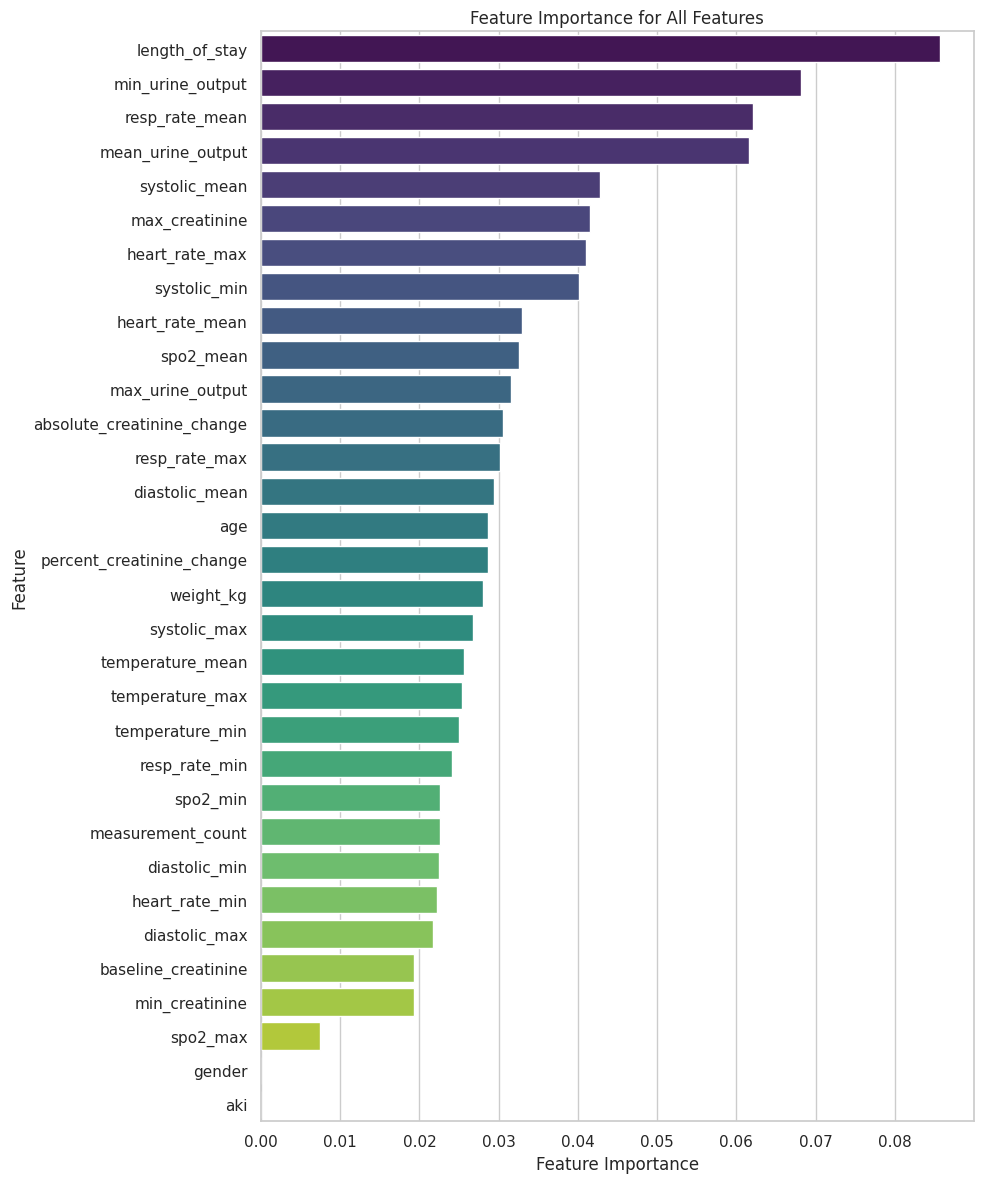


Feature Importance for All Features:
                   Feature  Importance
            length_of_stay        0.09
          min_urine_output        0.07
            resp_rate_mean        0.06
         mean_urine_output        0.06
             systolic_mean        0.04
            max_creatinine        0.04
            heart_rate_max        0.04
              systolic_min        0.04
           heart_rate_mean        0.03
                 spo2_mean        0.03
          max_urine_output        0.03
absolute_creatinine_change        0.03
             resp_rate_max        0.03
            diastolic_mean        0.03
                       age        0.03
 percent_creatinine_change        0.03
                 weight_kg        0.03
              systolic_max        0.03
          temperature_mean        0.03
           temperature_max        0.03
           temperature_min        0.03
             resp_rate_min        0.02
                  spo2_min        0.02
         measurement_count

In [ ]:
def perform_feature_selection(cleaned_data):
    exclude_cols = ['subject_id', 'hadm_id', 'hospital_expire_flag', 'first_measurement', 'last_measurement']
    feature_cols = [col for col in cleaned_data.columns if col not in exclude_cols]
    X = cleaned_data[feature_cols].copy()
    y = cleaned_data['hospital_expire_flag']

    if 'gender' in X.columns:
        X['gender'] = (X['gender'] == 'M').astype(int)

    imputer = SimpleImputer(strategy='median')
    X = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

    rf = RandomForestClassifier(
        n_estimators=150,
        max_depth=10,
        random_state=42
    )
    rf.fit(X, y)

    # Calculate feature importance
    importances = rf.feature_importances_
    importance_df = pd.DataFrame({
        'Feature': feature_cols,
        'Importance': importances
    }).sort_values(by='Importance', ascending=False)
    plt.figure(figsize=(10, 12))
    sns.barplot(data=importance_df, x='Importance', y='Feature', palette="viridis")
    plt.title('Feature Importance for All Features')
    plt.xlabel('Feature Importance')
    plt.tight_layout()
    plt.show()
    print("\nFeature Importance for All Features:")
    print(importance_df.round(3).to_string(index=False))
    return importance_df

all_feature_importances = perform_feature_selection(cleaned_data)


In [ ]:
num_dead_patients = cleaned_data[cleaned_data['hospital_expire_flag'] == 1].count()
num_survived_patients = cleaned_data[cleaned_data['hospital_expire_flag'] == 0].count()
print('Number of dead patients:', num_dead_patients['hospital_expire_flag'])
print('Number of survived patients:', num_survived_patients['hospital_expire_flag'])

Number of dead patients: 2226
Number of survived patients: 13474


In [ ]:
# Features selected from feature selection
selected_features = ['measurement_count', 'absolute_creatinine_change', 'percent_creatinine_change', 'max_creatinine', 'min_urine_output', 'mean_urine_output', 'diastolic_min', 'heart_rate_max', 'baseline_creatinine', 'min_creatinine', 'weight_kg']

X = cleaned_data[selected_features]
y = cleaned_data['hospital_expire_flag']


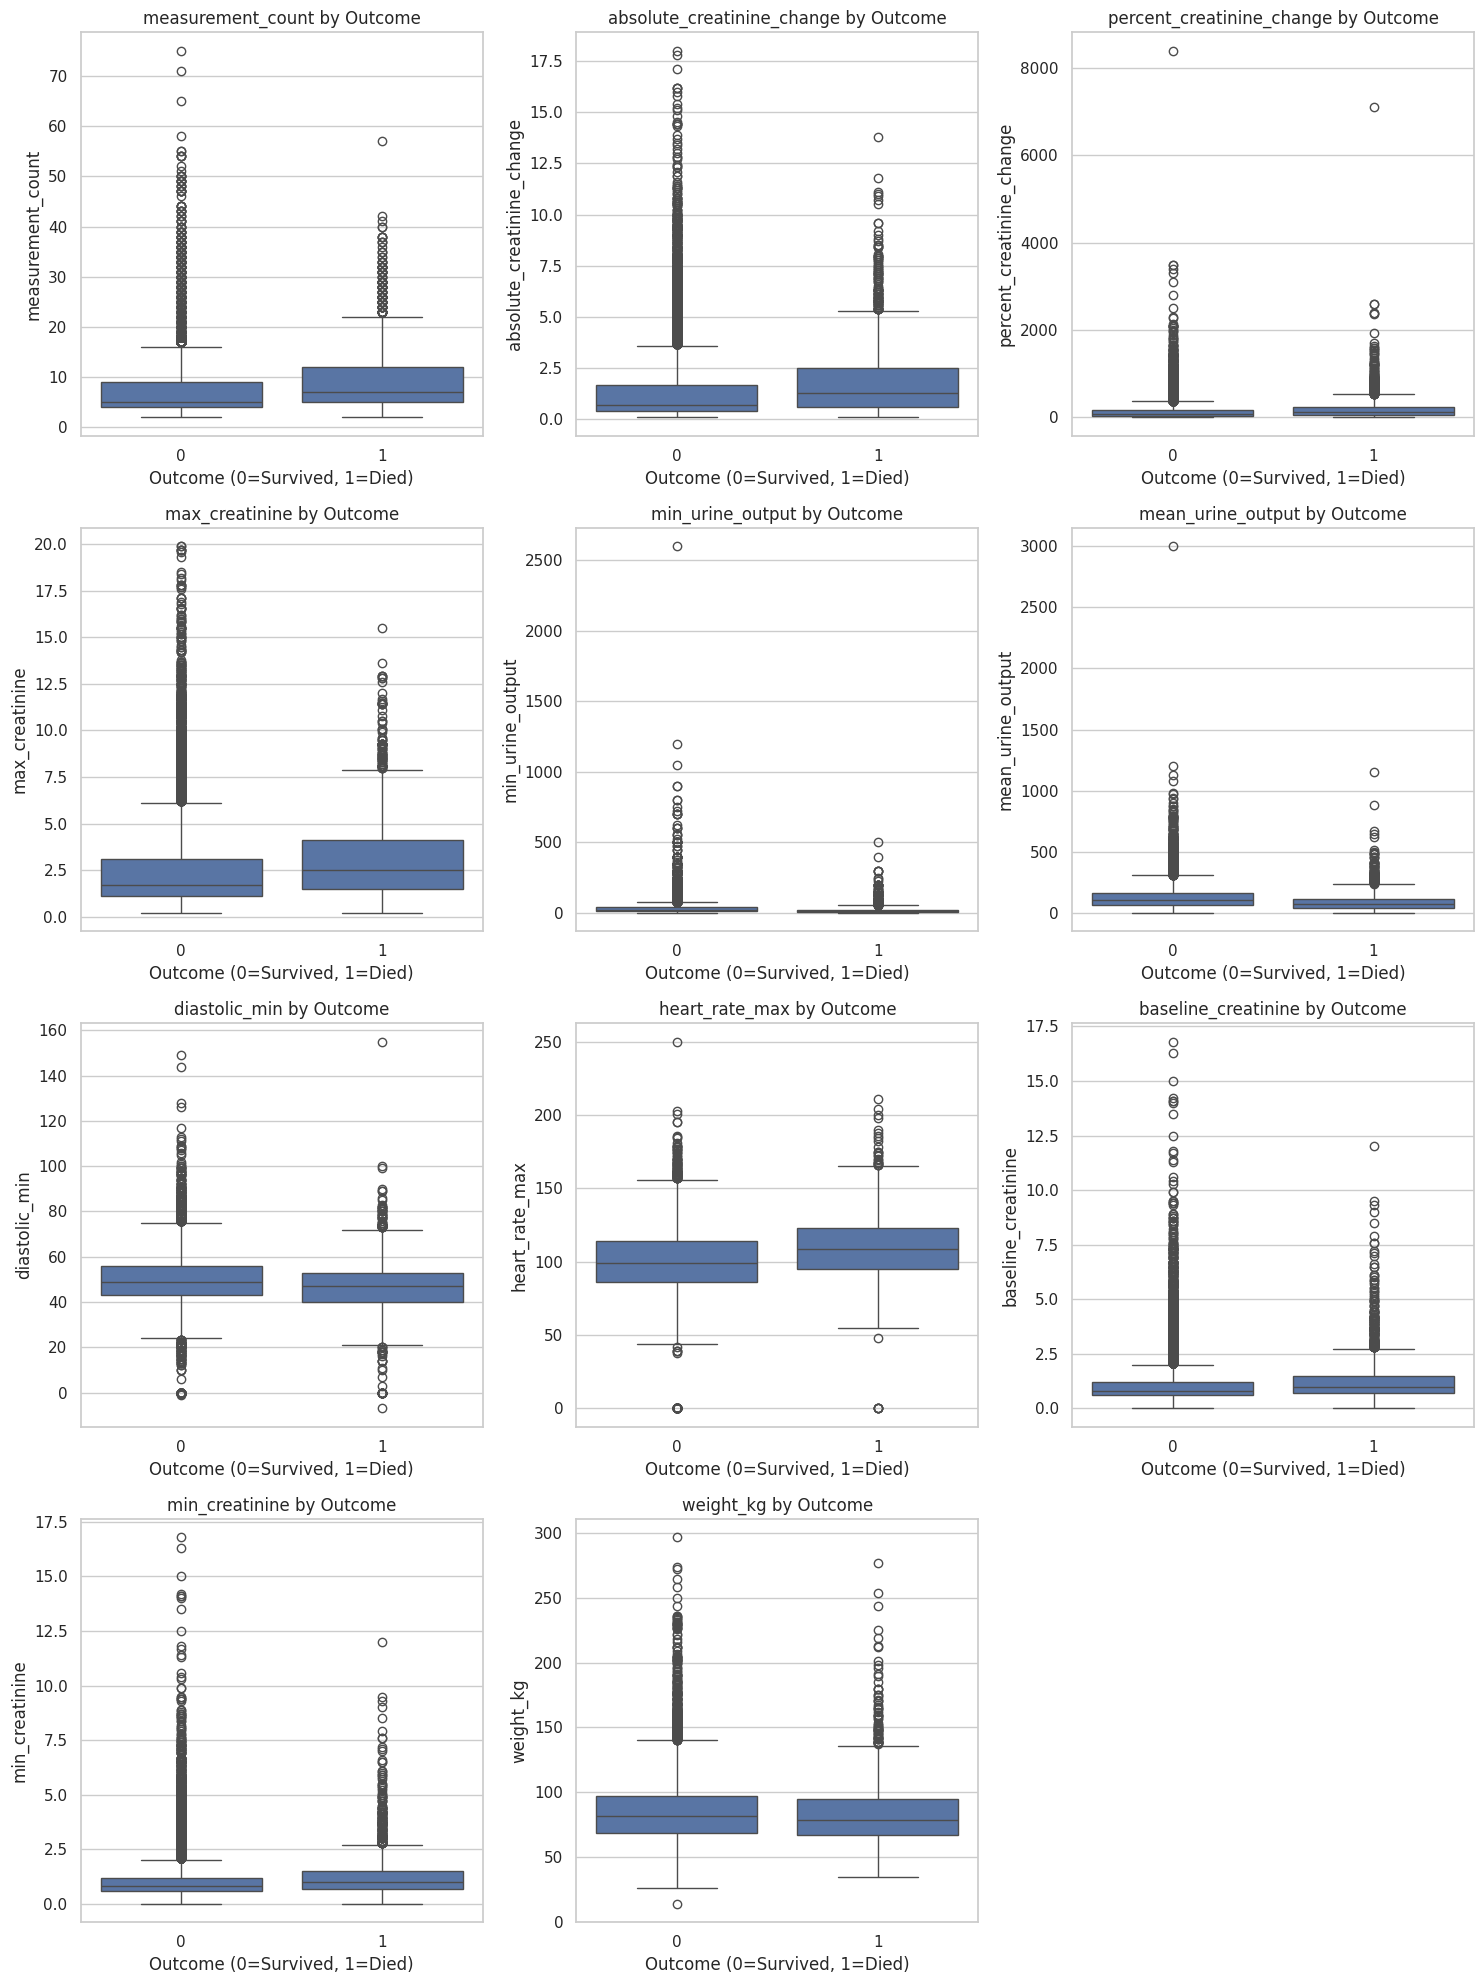

<ipython-input-93-90955110688d>:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=importances, x='Importance', y='Feature', palette="viridis")


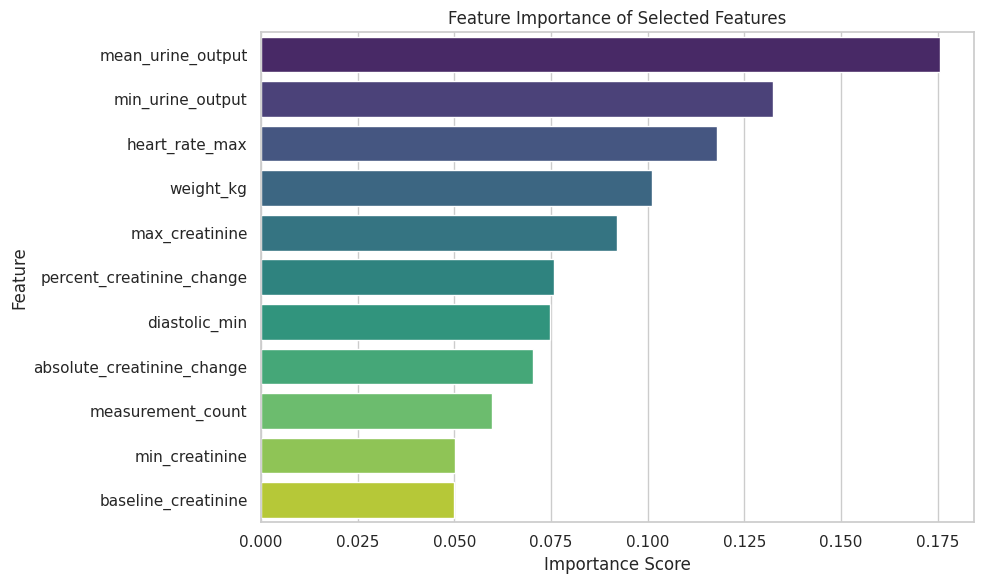

In [ ]:
def analyze_selected_features(data, selected_features):

    X = data[selected_features]
    y = data['hospital_expire_flag']

    n_rows = (len(selected_features) + 2) // 3
    plt.figure(figsize=(15, n_rows * 5))
    for i, feature in enumerate(selected_features, 1):
        plt.subplot(n_rows, 3, i)
        sns.boxplot(x='hospital_expire_flag', y=feature, data=data)
        plt.title(f'{feature} by Outcome')
        plt.xlabel('Outcome (0=Survived, 1=Died)')
    plt.tight_layout()
    plt.show()

    rf = RandomForestClassifier(n_estimators=150, max_depth=10, random_state=42)
    rf.fit(StandardScaler().fit_transform(X), y)

    importances = pd.DataFrame({
        'Feature': selected_features,
        'Importance': rf.feature_importances_
    }).sort_values('Importance', ascending=False)

    plt.figure(figsize=(10, 6))
    sns.barplot(data=importances, x='Importance', y='Feature', palette="viridis")
    plt.title('Feature Importance of Selected Features')
    plt.xlabel('Importance Score')
    plt.tight_layout()
    plt.show()

    return importances

importances = analyze_selected_features(cleaned_data, selected_features)

In [ ]:
# Handle missing values in features
X = handle_missing_and_infinite_values(X)


Missing values per column:
 measurement_count               0
absolute_creatinine_change      0
percent_creatinine_change       0
max_creatinine                  0
min_urine_output              316
mean_urine_output             316
diastolic_min                   0
heart_rate_max                  0
baseline_creatinine             0
min_creatinine                  0
weight_kg                      12
dtype: int64

Infinite values per column:
 measurement_count             0
absolute_creatinine_change    0
percent_creatinine_change     0
max_creatinine                0
min_urine_output              0
mean_urine_output             0
diastolic_min                 0
heart_rate_max                0
baseline_creatinine           0
min_creatinine                0
weight_kg                     0
dtype: int64


In [ ]:
X.columns.tolist()

['measurement_count',
 'absolute_creatinine_change',
 'percent_creatinine_change',
 'max_creatinine',
 'min_urine_output',
 'mean_urine_output',
 'diastolic_min',
 'heart_rate_max',
 'baseline_creatinine',
 'min_creatinine',
 'weight_kg']

## SMOTE

In [ ]:
# Split then training set and validation set
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)


In [ ]:
from imblearn.over_sampling import SMOTE

In [ ]:
#Apply SMOTE to the data
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In [ ]:
# Print class distribution before and after SMOTE
print("Before SMOTE:")
print(y_train.value_counts())

print("\nAfter SMOTE:")
print(pd.Series(y_train_resampled).value_counts())
X_train = X_train_resampled
y_train = y_train_resampled

Before SMOTE:
hospital_expire_flag
0    10779
1     1781
Name: count, dtype: Int64

After SMOTE:
hospital_expire_flag
1    10779
0    10779
Name: count, dtype: Int64


In [ ]:
# Data normalization
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [ ]:
# import necessary library
!pip install xgboost
import xgboost as xgb


In [ ]:
# Create DMatrix for XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=selected_features)
dtest = xgb.DMatrix(X_test, label=y_test, feature_names=selected_features)

# Set parameters
params = {
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'seed': 42,
    'max_depth': 3,
    'learning_rate': 0.05,
    'min_child_weight': 10,
    'n_estimators': 100,
    'reg_alpha': 0.1,
    'reg_lambda': 2
}

# Train the model
evallist = [(dtrain, 'train'), (dtest, 'eval')]
num_round = 100

bst = xgb.train(params, dtrain, num_round, evallist, early_stopping_rounds=10)


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:723: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [02:28:31] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	train-auc:0.73292	eval-auc:0.67273
[1]	train-auc:0.76350	eval-auc:0.68015
[2]	train-auc:0.76850	eval-auc:0.67932
[3]	train-auc:0.77918	eval-auc:0.68700
[4]	train-auc:0.77941	eval-auc:0.68703
[5]	train-auc:0.78900	eval-auc:0.68866
[6]	train-auc:0.78921	eval-auc:0.69143
[7]	train-auc:0.79287	eval-auc:0.69424
[8]	train-auc:0.79782	eval-auc:0.69244
[9]	train-auc:0.80118	eval-auc:0.69416
[10]	train-auc:0.80594	eval-auc:0.69540
[11]	train-auc:0.80705	eval-auc:0.69506
[12]	train-auc:0.80915	eval-auc:0.69536
[13]	train-auc:0.81259	eval-auc:0.69570
[14]	train-auc:0.81420	eval-auc:0.69492
[15]	train-auc:0.81479	eval-auc:0.69448
[16]	train-auc:0.81641	eval-auc:0.69612
[17]	train-auc:0.81745	eval-auc:0.69798
[18]	train-auc:0.81828	eval-auc:0.69755
[19]	train-auc:0.81906	eval-auc:0.69748
[20]	train-auc:0.82036	eval-auc:0.69920
[21]	train-auc:0.82125	eval-auc:0.69889
[22]	train-auc:0.82274	eval-auc:0.69884
[23]	train-auc:0.82749	eval-auc:0.69943
[24]	train-auc:0.82770	eval-auc:0.70167
[25]	train

In [ ]:
y_pred_prob_xgb = bst.predict(dtest)
y_pred = (y_pred_prob_xgb > 0.5).astype(int)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

print(classification_report(y_test, y_pred))
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)

              precision    recall  f1-score   support

         0.0       0.91      0.78      0.84      2695
         1.0       0.27      0.51      0.35       445

    accuracy                           0.74      3140
   macro avg       0.59      0.64      0.59      3140
weighted avg       0.82      0.74      0.77      3140

Confusion Matrix:
 [[2090  605]
 [ 219  226]]


In [ ]:
from sklearn.metrics import roc_auc_score
# AUC score
auc_score = roc_auc_score(y_test, y_pred_prob_xgb)
print(f"ROC-AUC Score: {auc_score:.4f}")


ROC-AUC Score: 0.7134


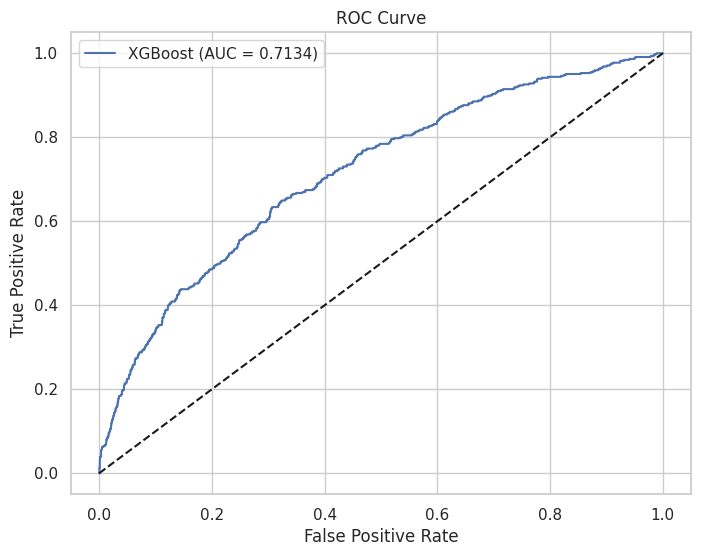

In [ ]:
from sklearn.metrics import roc_curve
# Draw ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob_xgb)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f"XGBoost (AUC = {auc_score:.4f})")
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()


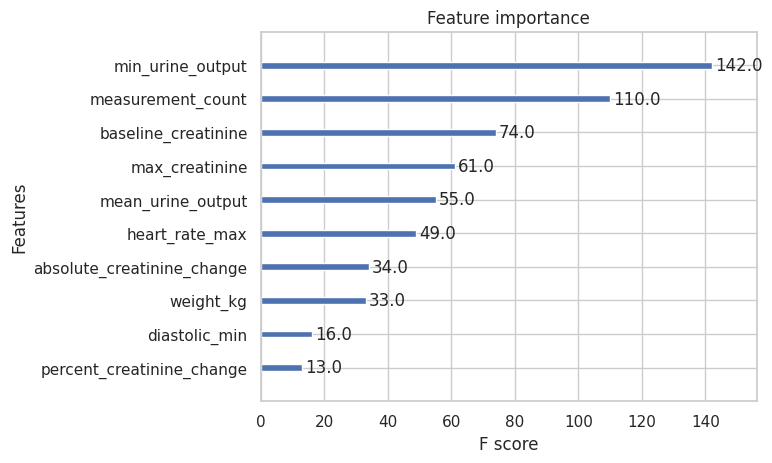

In [ ]:
# importance of each feature
xgb.plot_importance(bst, max_num_features=10)
plt.show()


In [ ]:
from sklearn.model_selection import GridSearchCV
# grid search,  takes at least 1 hour to run

xgb_clf = xgb.XGBClassifier(objective='binary:logistic', seed=42)
param_grid = {
    'max_depth': [3, 5, 9],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 400, 600],
    # 'scale_pos_weight': [1],
    'min_child_weight': [5,10],
    'reg_alpha': [0,0.1],
    'reg_lambda': [1,2],
    'subsample': [0.7, 1]
}

grid_search = GridSearchCV(estimator=xgb_clf, param_grid=param_grid, scoring='roc_auc', cv=5, n_jobs=-1, verbose=2)

grid_search.fit(X_train, y_train)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best AUC: {grid_search.best_score_:.4f}")


Fitting 5 folds for each of 432 candidates, totalling 2160 fits
Best parameters: {'learning_rate': 0.05, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 600, 'reg_alpha': 0, 'reg_lambda': 2, 'subsample': 0.7}
Best AUC: 0.9608


In [ ]:
#Update the model with the best parameters:
best_params = grid_search.best_params_
bst = xgb.train({**params, **best_params}, dtrain, num_round, evallist, early_stopping_rounds=10)


[0]	train-auc:0.87315	eval-auc:0.66831
[1]	train-auc:0.89106	eval-auc:0.67064
[2]	train-auc:0.89881	eval-auc:0.66877
[3]	train-auc:0.90004	eval-auc:0.66998
[4]	train-auc:0.90529	eval-auc:0.67045
[5]	train-auc:0.90743	eval-auc:0.67296
[6]	train-auc:0.90791	eval-auc:0.67627
[7]	train-auc:0.91234	eval-auc:0.68211
[8]	train-auc:0.91676	eval-auc:0.67995
[9]	train-auc:0.91962	eval-auc:0.68345
[10]	train-auc:0.92009	eval-auc:0.68562


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:723: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [03:07:20] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[11]	train-auc:0.92224	eval-auc:0.68592
[12]	train-auc:0.92176	eval-auc:0.68646
[13]	train-auc:0.92447	eval-auc:0.68743
[14]	train-auc:0.92581	eval-auc:0.68785
[15]	train-auc:0.92751	eval-auc:0.68988
[16]	train-auc:0.92869	eval-auc:0.69099
[17]	train-auc:0.93031	eval-auc:0.68974
[18]	train-auc:0.93216	eval-auc:0.69146
[19]	train-auc:0.93283	eval-auc:0.69256
[20]	train-auc:0.93298	eval-auc:0.69277
[21]	train-auc:0.93451	eval-auc:0.69224
[22]	train-auc:0.93607	eval-auc:0.69268
[23]	train-auc:0.93810	eval-auc:0.69281
[24]	train-auc:0.93949	eval-auc:0.69298
[25]	train-auc:0.94076	eval-auc:0.69259
[26]	train-auc:0.94129	eval-auc:0.69294
[27]	train-auc:0.94202	eval-auc:0.69424
[28]	train-auc:0.94281	eval-auc:0.69433
[29]	train-auc:0.94378	eval-auc:0.69464
[30]	train-auc:0.94493	eval-auc:0.69494
[31]	train-auc:0.94560	eval-auc:0.69515
[32]	train-auc:0.94640	eval-auc:0.69594
[33]	train-auc:0.94702	eval-auc:0.69672
[34]	train-auc:0.94788	eval-auc:0.69734
[35]	train-auc:0.94859	eval-auc:0.69806


              precision    recall  f1-score   support

         0.0       0.89      0.87      0.88      2695
         1.0       0.33      0.38      0.35       445

    accuracy                           0.80      3140
   macro avg       0.61      0.62      0.62      3140
weighted avg       0.81      0.80      0.81      3140

Confusion Matrix:
 [[2344  351]
 [ 276  169]]
ROC-AUC Score: 0.6991


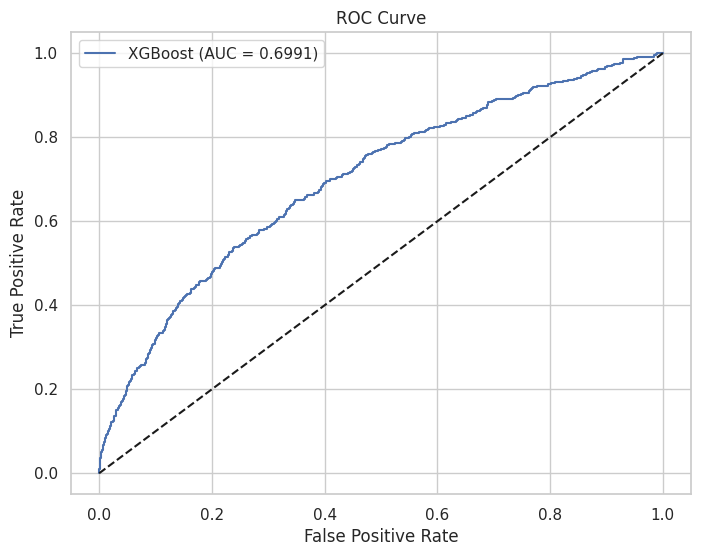

In [ ]:
#evaluate the new model
y_pred_prob_xgb1 = bst.predict(dtest)
y_pred = (y_pred_prob_xgb1 > 0.5).astype(int)
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)

auc_score = roc_auc_score(y_test, y_pred_prob_xgb1)
print(f"ROC-AUC Score: {auc_score:.4f}")
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob_xgb1)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f"XGBoost (AUC = {auc_score:.4f})")
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

In [ ]:
#Perform cross-validation to assess the model's generalizability.
cv_results = xgb.cv(params, dtrain, num_boost_round=100, nfold=5, metrics='auc', early_stopping_rounds=10, seed=42)
print(cv_results)


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [03:07:22] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


    train-auc-mean  train-auc-std  test-auc-mean  test-auc-std
0             0.74           0.00           0.73          0.01
1             0.74           0.00           0.74          0.01
2             0.75           0.01           0.75          0.01
3             0.77           0.01           0.76          0.02
4             0.78           0.01           0.78          0.02
..             ...            ...            ...           ...
95            0.89           0.00           0.88          0.01
96            0.89           0.00           0.88          0.01
97            0.89           0.00           0.89          0.01
98            0.89           0.00           0.89          0.01
99            0.89           0.00           0.89          0.01

[100 rows x 4 columns]


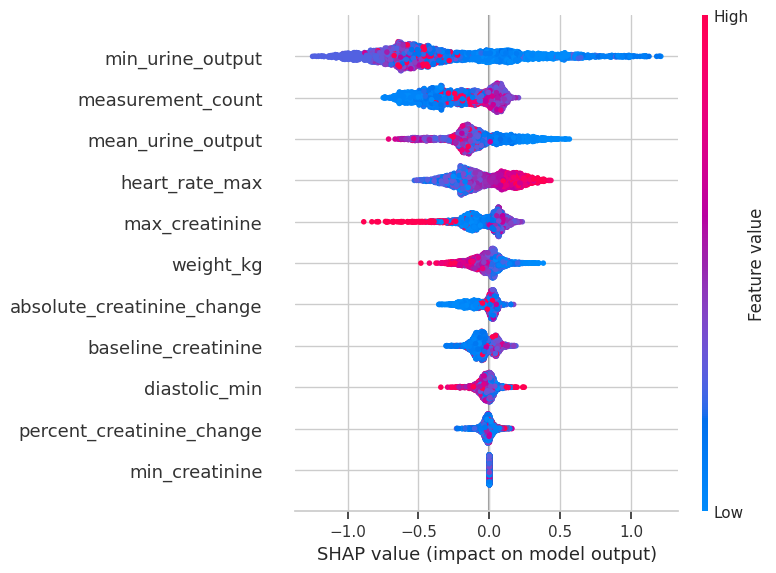

In [ ]:
#Use SHAP values to interpret the impact of features.
!pip install shap
import shap

explainer = shap.TreeExplainer(bst)
shap_values = explainer.shap_values(X_test)

# Summary plot
shap.summary_plot(shap_values, X_test, feature_names=selected_features)


In [ ]:
bst.save_model('xgboost_aki_mortality.model')


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [03:07:39] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)


In [ ]:
# Initialize and train the logistic regression model
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(random_state=42)
logreg.fit(X_train, y_train)

LogisticRegression(random_state=42)

In [ ]:
# Make predictions
y_pred_prob_LR = logreg.predict_proba(X_test)[:, 1]  # Probability of the positive class (mortality)
y_pred = (y_pred_prob_LR > 0.5).astype(int)  # Convert probabilities to binary predictions

In [ ]:
# Classification report
print(classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)

              precision    recall  f1-score   support

         0.0       0.91      0.61      0.73      2695
         1.0       0.22      0.65      0.32       445

    accuracy                           0.62      3140
   macro avg       0.57      0.63      0.53      3140
weighted avg       0.81      0.62      0.68      3140

Confusion Matrix:
 [[1649 1046]
 [ 156  289]]


ROC-AUC Score: 0.6731


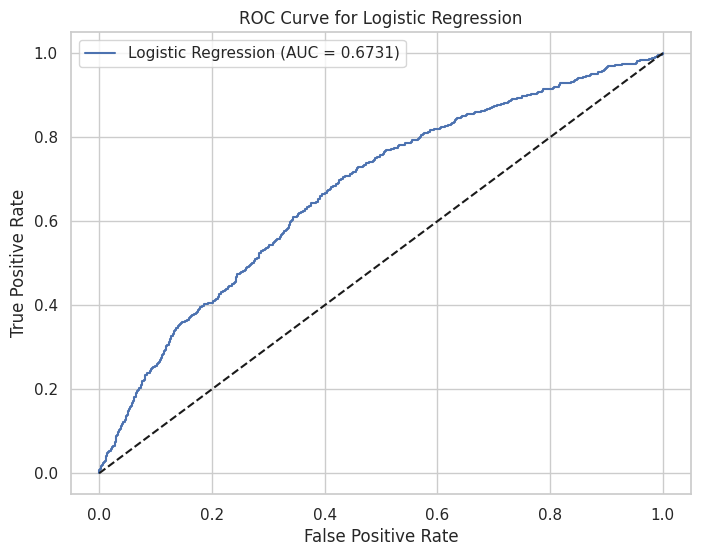

In [ ]:
# Calculate and display the ROC-AUC score
roc_auc = roc_auc_score(y_test, y_pred_prob_LR)
print(f"ROC-AUC Score: {roc_auc:.4f}")

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob_LR)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"Logistic Regression (AUC = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Logistic Regression')
plt.legend()
plt.show()

In [ ]:
# random forest classifier
from sklearn.ensemble import RandomForestClassifier

# split into train and test sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

#X_train = scaler.fit_transform(X_train)
#X_test = scaler.transform(X_test)

# create an rf model
rf_model = RandomForestClassifier(n_estimators=100, bootstrap = True,max_features = 'sqrt')
rf_model.fit(X_train, y_train)

RandomForestClassifier()

In [ ]:

# Actual class predictions
y_pred = rf_model.predict(X_test)

# Probabilities for each class
y_probs = rf_model.predict_proba(X_test)[:, 1]


In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
# Accuracy, Confusion Matrix and Classification report
accuracy = accuracy_score(y_test, y_pred)
confusion = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy:.2f}")
print("Confusion Matrix:\n", confusion)
print("Classification Report:\n", report)

Accuracy: 0.83
Confusion Matrix:
 [[2469  226]
 [ 318  127]]
Classification Report:
               precision    recall  f1-score   support

         0.0       0.89      0.92      0.90      2695
         1.0       0.36      0.29      0.32       445

    accuracy                           0.83      3140
   macro avg       0.62      0.60      0.61      3140
weighted avg       0.81      0.83      0.82      3140



In [ ]:
# Calculate the AUROC score
auroc = roc_auc_score(y_test, y_probs)

print(f"AUROC: {auroc:.2f}")

AUROC: 0.70


In [ ]:
from sklearn.metrics import roc_auc_score

# Calculate roc auc
roc_value = roc_auc_score(y_test, y_probs)

In [ ]:
roc_value

0.7012991182172563

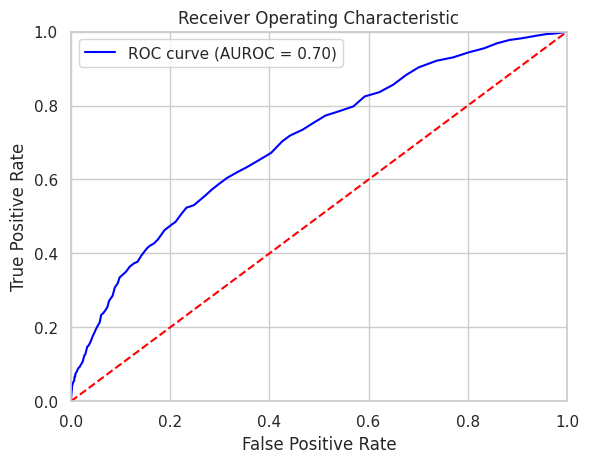

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, y_probs)

plt.figure()
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUROC = {auroc:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="upper left")
plt.show()

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
# took like 30+ mins to run, and 200 fits failed out of 500 lol

rf_model2 = RandomForestClassifier(random_state=42)

# Set up the hyperparameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

# Set up RandomizedSearchCV instead
random_search = RandomizedSearchCV(estimator=rf_model2,
                                   param_distributions=param_grid,
                                   n_iter=100,  # Number of random combinations to try
                                   cv=5,
                                   n_jobs=-1,
                                   verbose=2,
                                   scoring='roc_auc',
                                   random_state=42)

# Fit RandomizedSearchCV
random_search.fit(X_train, y_train)

# Print the best parameters
print("Best parameters found: ", random_search.best_params_)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
200 fits failed out of a total of 500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
200 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1466, in wrapper
    estimator._validate_params()
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/util

Best parameters found:  {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': None}


In [ ]:
# lets try with hyperparameter tuning and cross validation
# takes too long to run, i think it ran for at least 2 hours lol
from sklearn.model_selection import train_test_split, GridSearchCV

rf_model2 = RandomForestClassifier(random_state=42)

# Set up the hyperparameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

# Set up GridSearchCV
grid_search = GridSearchCV(estimator=rf_model2,
                           param_grid=param_grid,
                           cv=5,
                           n_jobs=-1,
                           verbose=2,
                           scoring='roc_auc')

# Fit GridSearchCV
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 243 candidates, totalling 1215 fits


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
405 fits failed out of a total of 1215.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
270 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py"

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [None, 10, 20],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 200]},
             scoring='roc_auc', verbose=2)

In [ ]:

# Print the best parameters
print("Best parameters found: ", grid_search.best_params_)

# Evaluate the best model on the test set
best_rf = grid_search.best_estimator_
y_pred_prob_RF = best_rf.predict_proba(X_test)[:, 1]
auroc = roc_auc_score(y_test, y_pred_prob_RF)
print(f"AUROC of the best model: {auroc:.2f}")

# Additional evaluation
y_pred = best_rf.predict(X_test)
print(classification_report(y_test, y_pred))

Best parameters found:  {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
AUROC of the best model: 0.71
              precision    recall  f1-score   support

         0.0       0.89      0.91      0.90      2695
         1.0       0.37      0.31      0.34       445

    accuracy                           0.83      3140
   macro avg       0.63      0.61      0.62      3140
weighted avg       0.82      0.83      0.82      3140



In [ ]:
print(confusion_matrix(y_test, y_pred))

[[2464  231]
 [ 307  138]]


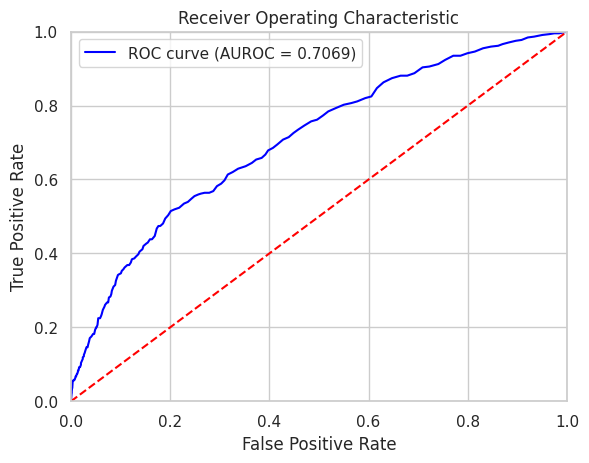

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob_RF)

plt.figure()
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUROC = {auroc:.4f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="upper left")
plt.show()

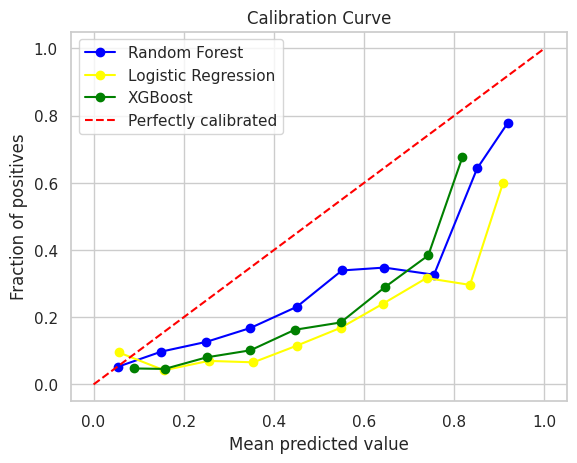

In [ ]:
#calibration curve & nri
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt

fraction_of_positives_RF, mean_predicted_value_RF = calibration_curve(y_test, y_pred_prob_RF, n_bins=10)
fraction_of_positives_LR, mean_predicted_value_LR = calibration_curve(y_test, y_pred_prob_LR, n_bins=10)
fraction_of_positives_xgb, mean_predicted_value_xgb = calibration_curve(y_test, y_pred_prob_xgb, n_bins=10)

# draw calibration curve
plt.figure()
plt.plot(mean_predicted_value_RF, fraction_of_positives_RF, marker='o', color='blue', label='Random Forest')
plt.plot(mean_predicted_value_LR, fraction_of_positives_LR, marker='o', color='yellow', label='Logistic Regression')
plt.plot(mean_predicted_value_xgb, fraction_of_positives_xgb, marker='o', color='green', label='XGBoost')
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Perfectly calibrated')

plt.xlabel('Mean predicted value')
plt.ylabel('Fraction of positives')
plt.title('Calibration Curve')
plt.legend(loc='upper left')
plt.show()


In [ ]:
from sklearn.metrics import roc_curve, auc

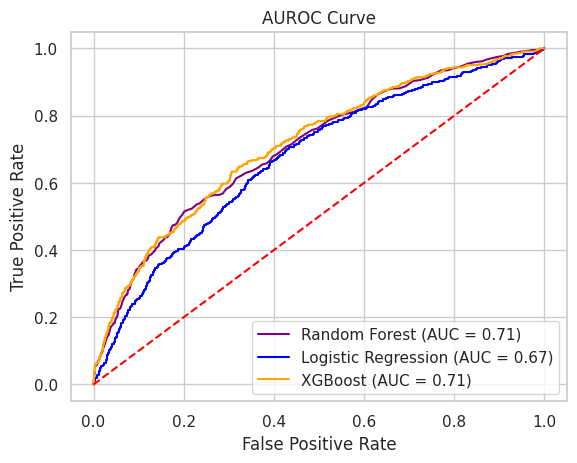

In [ ]:


# Compute ROC curve and ROC area for each model
fpr_RF, tpr_RF, thresholds_RF = roc_curve(y_test, y_pred_prob_RF)
roc_auc_RF = auc(fpr_RF, tpr_RF)

fpr_LR, tpr_LR, thresholds_LR = roc_curve(y_test, y_pred_prob_LR)
roc_auc_LR = auc(fpr_LR, tpr_LR)

fpr_xgb, tpr_xgb, thresholds_xgb = roc_curve(y_test, y_pred_prob_xgb)
roc_auc_xgb = auc(fpr_xgb, tpr_xgb)

# Plotting the AUROC curves
plt.figure()
plt.plot(fpr_RF, tpr_RF, color='purple', label='Random Forest (AUC = {:.2f})'.format(roc_auc_RF))
plt.plot(fpr_LR, tpr_LR, color='blue', label='Logistic Regression (AUC = {:.2f})'.format(roc_auc_LR))
plt.plot(fpr_xgb, tpr_xgb, color='orange', label='XGBoost (AUC = {:.2f})'.format(roc_auc_xgb))
plt.plot([0, 1], [0, 1], color='red', linestyle='--')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('AUROC Curve')
plt.legend(loc='lower right')
plt.show()

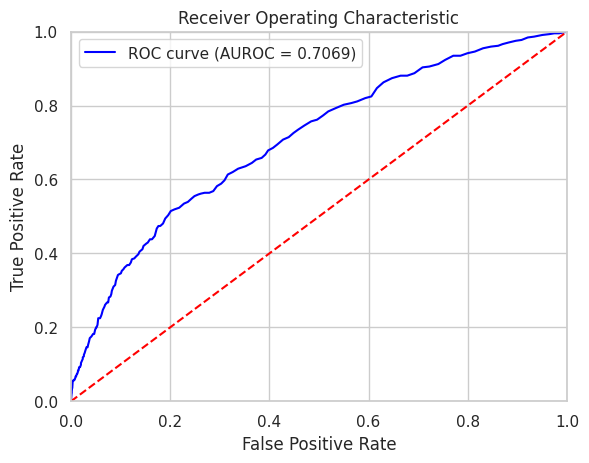

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob_RF)

plt.figure()
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUROC = {auroc:.4f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="upper left")
plt.show()
